# Analyze data from education systems

## <i>Exploration and data cleaning</i>

My mission here for <i><strong>academy</strong></i> is to study World Bank data related to education to informe their plans for international expansion.
<br><br>
After cleaning the dataset, we have :
1. Select the most relevant indicators to respond to the demand ;
2. Explored the data using principal component analysis (PCA) ;
3. Used the k-means clustering method to target countries with high potential customers for <i>academy</i> ;
4. Analyzed the indicators of the top 3 potential future Academy customers and their evolution until 2060 ;
5. Selected the country in which <i>academy</i> should operate in priority.

<br><br>
<u><strong>Summary</strong></u> :<br>
<br>
<strong>Tools </strong><br>
 
<strong>I. Select and clean World Bank data</strong><br>
     -- A. [EdStatsCountry.csv](http://localhost:8888/edit/EdStatsCountry.csv) : exploration and data cleaning [(here)](#another_cell_a)<br>
     -- B. [EdStatsCountry-Series.csv](http://localhost:8888/edit/EdStatsCountry-Series.csv) : exploration and data cleaning [(here)](#another_cell_b)<br>
     -- C. [EdStatsData.csv](http://localhost:8888/edit/EdStatsData.csv) : exploration and data cleaning [(here)](#another_cell_c)<br>
     ---- <i>a. Access to education<br>
     ---- b. Graduation<br>
     ---- c. Education-related expenses <br>
     ---- d. Teachers <br></i>
     -- D. [EdStatsFootNote.csv](http://localhost:8888/edit/EdStatsFootNote.csv) : exploration and data cleaning [(here)](#another_cell_d)<br>
     -- E. [EdStatsSeries.csv](http://localhost:8888/edit/EdStatsSeries.csv) : exploration and data cleaning [(here)](#another_cell_e)<br>
     -- F. Merging, cleaning and data augmentation [(here)](#another_cell_f)<br>
     ---- <i>a. Merge indicators and add regions<br>
     ---- b. Check missing values in the dataframe<br>
     ---- c. Isolate and drop countries which have more than 20% of missing values<br>
     ---- d. Clean "Region" column<br>
     ---- e. Fill in missing values with the last non-missing value from previous years</i>
     
<br><strong>II. Principal component analysis (PCA) on 2010</strong><br>
     -- A. Pre-processing [(here)](#another_cell_g)<br>
     -- B. Explained Variance Ratio and Scree plot [(here)](#another_cell_h)<br>
     -- C. Correlation circles and projections of points [(here)](#another_cell_i)<br>

<br><strong>III. KMeans clustering</strong><br>
     -- A. Finding the optimal number of clusters for classification (Elbow method) [(here)](#another_cell_j)<br>
     -- B. Factorial plan [(here)](#another_cell_k)<br>
     -- C. Centroid analysis [(here)](#another_cell_l)<br>
     -- D. Clusters composition [(here)](#another_cell_m)<br>
     -- E. Conclusion (K-Means) and recommendations for academy [(here)](#another_cell_n)<br>
     
<br><strong>IV. Scoring of the best cluster and data exploration of the top 3</strong><br>
     -- A. Scoring of the best cluster on 2010 and top 3 selection [(here)](#another_cell_o)<br>
     -- B. Exploration of the top 3 [(here)](#another_cell_p)<br>
     ---- <i>a. Focus on internet acess<br>
     ---- b. Focus on school life expectancy (secondary school)<br>
     ---- c. Wittgenstein projection indicator (mean years of schooling at 25 years old)<br></i>
     
<strong> Conclusion [(here)](#another_cell_q)</strong> 

 <a id='another_cell_0'></a>

### Tools

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import warnings
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [57]:
#Check null values function :
def check_nan(data, column):
    if len(data[data[column].isnull()]) == 0:
        print ("The column", column, "does not contain any missing values")
    else :
        print("The column", column, "contain ", len(data[data[column].isnull()]), " missing values")

In [58]:
#Check duplicates function :
def check_duplicates(data, column):
    n = len(data.index)
    if len(data[column].drop_duplicates()) == n :
        print ("The column", column, "does not contain duplicates")
    else :
        print("The column", column, "contains ", len(data[data[column].duplicated()]), " duplicates.")
        return data[data[column].duplicated()]

In [59]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    '''Display correlation circles, one for each factorial plane'''

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialize the matplotlib figure
            #fig, ax = plt.subplots(figsize=(8,8))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='10', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation Circle (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialize the matplotlib figure      
            #fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            #plt.show(block=False)
            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
   

def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.show(block=False)

## I. Select and clean World Bank data

<a id='another_cell_a'></a>

### A. [EdStatsCountry.csv](http://localhost:8888/edit/EdStatsCountry.csv) : exploration and data cleaning

- Dataset description :

In [61]:
edstatscountry = pd.read_csv('EdStatsCountry.csv', sep=',')

In [6]:
edstatscountry.head()

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from offici...,Latin America & Caribbean,High income: nonOECD,AW,...,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN,NaN
1,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,...,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2012.0,2000,NaN
2,AGO,Angola,Angola,People's Republic of Angola,AO,Angolan kwanza,"April 2013 database update: Based on IMF data,...",Sub-Saharan Africa,Upper middle income,AO,...,General Data Dissemination System (GDDS),1970,"Malaria Indicator Survey (MIS), 2011","Integrated household survey (IHS), 2008",NaN,2015,NaN,NaN,2005,NaN
3,ALB,Albania,Albania,Republic of Albania,AL,Albanian lek,NaN,Europe & Central Asia,Upper middle income,AL,...,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2008/09",Living Standards Measurement Study Survey (LSM...,Yes,2012,2010.0,2012.0,2006,NaN
4,AND,Andorra,Andorra,Principality of Andorra,AD,Euro,NaN,Europe & Central Asia,High income: nonOECD,AD,...,NaN,2011. Population figures compiled from adminis...,NaN,NaN,Yes,NaN,NaN,2006.0,NaN,NaN


In [7]:
edstatscountry.shape

(241, 32)

In [8]:
edstatscountry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 32 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Country Code                                       241 non-null    object 
 1   Short Name                                         241 non-null    object 
 2   Table Name                                         241 non-null    object 
 3   Long Name                                          241 non-null    object 
 4   2-alpha code                                       238 non-null    object 
 5   Currency Unit                                      215 non-null    object 
 6   Special Notes                                      145 non-null    object 
 7   Region                                             214 non-null    object 
 8   Income Group                                       214 non-null    object 
 9   WB-2 code 

- Check null and duplicates values :

In [9]:
check_nan(edstatscountry, "Country Code")
check_duplicates(edstatscountry, "Country Code")

The column Country Code does not contain any missing values
The column Country Code does not contain duplicates


In [10]:
check_nan(edstatscountry, "Long Name")
check_duplicates(edstatscountry, "Long Name")

The column Long Name does not contain any missing values
The column Long Name does not contain duplicates


In [11]:
check_nan(edstatscountry, "Region")

The column Region contain  27  missing values


- Check mask values :

In [62]:
mask_nan = (edstatscountry['Long Name'].isnull()) | (edstatscountry['Region'].isnull())
print("Missing values concern these country codes :", edstatscountry[mask_nan]["Long Name"].unique())

Missing values concern these country codes : ['Arab World' 'East Asia & Pacific (developing only)'
 'East Asia & Pacific (all income levels)'
 'Europe & Central Asia (developing only)'
 'Europe & Central Asia (all income levels)' 'Euro area' 'European Union'
 'Gibraltar' 'High income' 'Heavily indebted poor countries (HIPC)'
 'Latin America & Caribbean (developing only)'
 'Latin America & Caribbean (all income levels)'
 'Least developed countries: UN classification' 'Low income'
 'Lower middle income' 'Low & middle income'
 'Middle East & North Africa (all income levels)' 'Middle income'
 'Middle East & North Africa (developing only)' 'North America' 'Nauru'
 'OECD members' 'South Asia' 'Sub-Saharan Africa (developing only)'
 'Sub-Saharan Africa (all income levels)' 'Upper middle income' 'World']


<div class="alert-success">
    <u>Notice</u> :
<i><br><li> This file contains 32 variables for 241 countries</br></li>
<li> The only variables that will interest us for the mission are the following: "Country code" (0), "Long name" (3) and "Region" (7)</li>
</i></div>
<div class="alert-warning">
    <u>Warning</u> :
<li> It should be noted that the "Region" column contains 27 missing values</li>
</i></div>

- New dataframe with our interesting variables :

In [63]:
regions = edstatscountry.iloc[0:240, [0,3,7]]
regions.head()

,Country Code,Long Name,Region
0,ABW,Aruba,Latin America & Caribbean
1,AFG,Islamic State of Afghanistan,South Asia
2,AGO,People's Republic of Angola,Sub-Saharan Africa
3,ALB,Republic of Albania,Europe & Central Asia
4,AND,Principality of Andorra,Europe & Central Asia


 <a id='another_cell_b'></a>


### B. [EdStatsCountry-Series.csv](http://localhost:8888/edit/EdStatsCountry-Series.csv) : exploration and data cleaning

- Dataset descrption :

In [14]:
edstatscountryseries = pd.read_csv('EdStatsCountry-Series.csv', sep=',')

In [15]:
edstatscountryseries.head()

,CountryCode,SeriesCode,DESCRIPTION,Unnamed: 3
0,ABW,SP.POP.TOTL,Data sources : United Nations World Population...,NaN
1,ABW,SP.POP.GROW,Data sources: United Nations World Population ...,NaN
2,AFG,SP.POP.GROW,Data sources: United Nations World Population ...,NaN
3,AFG,NY.GDP.PCAP.PP.CD,Estimates are based on regression.,NaN
4,AFG,SP.POP.TOTL,Data sources : United Nations World Population...,NaN


In [16]:
edstatscountryseries.shape

(613, 4)

In [17]:
edstatscountryseries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryCode  613 non-null    object 
 1   SeriesCode   613 non-null    object 
 2   DESCRIPTION  613 non-null    object 
 3   Unnamed: 3   0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 19.3+ KB


<div class="alert-danger">
<i>☛ No variable interests us in this file</li>
</i></div>

  <a id='another_cell_c'></a>

### C. [EdStatsData.csv](http://localhost:8888/edit/EdStatsData.csv) : exploration and data cleaning


- Dataset description :

In [64]:
edstatsdata = pd.read_csv('EdStatsData.csv', sep=',')

In [19]:
edstatsdata.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,54.822121,54.894138,56.209438,57.267109,57.991138,59.36554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
edstatsdata.shape

(886930, 70)

In [21]:
edstatsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886930 entries, 0 to 886929
Data columns (total 70 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Name    886930 non-null  object 
 1   Country Code    886930 non-null  object 
 2   Indicator Name  886930 non-null  object 
 3   Indicator Code  886930 non-null  object 
 4   1970            72288 non-null   float64
 5   1971            35537 non-null   float64
 6   1972            35619 non-null   float64
 7   1973            35545 non-null   float64
 8   1974            35730 non-null   float64
 9   1975            87306 non-null   float64
 10  1976            37483 non-null   float64
 11  1977            37574 non-null   float64
 12  1978            37576 non-null   float64
 13  1979            36809 non-null   float64
 14  1980            89122 non-null   float64
 15  1981            38777 non-null   float64
 16  1982            37511 non-null   float64
 17  1983      

<div class="alert-success">
    <u>Notice</u> :
<i><br><li> This file contains 70 columns inclunding years between 1970 and 2100, Country codes and their names, indicator codes and their names too</li>
<li> After 2015, there is a lot of null values (more than 98% of the entire dataset on 2016 and even more on 2017)</li>
<li> We will focus on the variables after 2010 (2010 being our most complete year)</li>
</i></div>

In [65]:
#new df with only variables between 2010 and 2060
df = edstatsdata.iloc[0:886929, [1,2,44,45,46,47,48,49,52,56,60]]
df.head()

,Country Code,Indicator Name,2010,2011,2012,2013,2014,2015,2020,2040,2060
0,ARB,"Adjusted net enrolment rate, lower secondary, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARB,"Adjusted net enrolment rate, lower secondary, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ARB,"Adjusted net enrolment rate, lower secondary, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARB,"Adjusted net enrolment rate, lower secondary, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ARB,"Adjusted net enrolment rate, primary, both sex...",85.211998,85.24514,86.101669,85.51194,85.320152,NaN,NaN,NaN,NaN


In [66]:
#select only non null values on 2010 (our most complete year)
df = df.loc[df['2010'].notnull(), ['Country Code','Indicator Name','2010','2011','2012','2013','2014','2015','2020','2040','2060']]
df

,Country Code,Indicator Name,2010,2011,2012,2013,2014,2015,2020,2040,2060
4,ARB,"Adjusted net enrolment rate, primary, both sex...",85.211998,85.245140,86.101669,85.511940,85.320152,NaN,NaN,NaN,NaN
5,ARB,"Adjusted net enrolment rate, primary, female (%)",82.871651,82.861389,84.401413,83.914032,83.820831,NaN,NaN,NaN,NaN
6,ARB,"Adjusted net enrolment rate, primary, gender p...",0.947620,0.946700,0.962080,0.964090,0.966200,NaN,NaN,NaN,NaN
7,ARB,"Adjusted net enrolment rate, primary, male (%)",87.452583,87.526520,87.728172,87.039879,86.753387,NaN,NaN,NaN,NaN
12,ARB,Adjusted net intake rate to Grade 1 of primary...,76.197044,76.474968,77.319366,76.566711,76.620567,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
886917,ZWE,Wittgenstein Projection: Population in thousan...,799.570000,NaN,NaN,NaN,NaN,721.56,660.67,407.10,212.14
886918,ZWE,Wittgenstein Projection: Population in thousan...,1614.840000,NaN,NaN,NaN,NaN,1474.43,1360.77,870.21,494.23
886919,ZWE,Wittgenstein Projection: Population in thousan...,1401.820000,NaN,NaN,NaN,NaN,1722.96,2052.78,3104.10,3469.66
886920,ZWE,Wittgenstein Projection: Population in thousan...,1608.650000,NaN,NaN,NaN,NaN,1873.55,2154.54,2970.06,3106.84


In [67]:
len(df["Indicator Name"].unique())

2568

<div class="alert-success">
    <u>Notice</u> :
<i><br><li> Their is 2568 unique indicators in this dataframe
<br><li> We will seek and select only relevant variables for the mission
<br><strong>These variables must respond to these 4 themes</strong> : "Access to education", "Graduation", "Expenses related to education" and "Teachers" :
    <br>☛ Regarding the <strong>access to education</strong>, we would like to know the level of internet access and then the percentage of enrolment in high school (secondary school) and university (tertiary school) ;
<br>☛ Regarding the <strong>level of graduation</strong>, we would like to know the number of graduates and the average number of years in school in secondary and tertiary school ;
<br>☛ Regarding the <strong>expenses related to education</strong>, we would like to know the level of expenditures for secondary and tertiary school ;
<br>☛ Regarding the <strong>teachers</strong>, we would like to know more about teachers' qualification in secondary and tertiary school.
</li></i></div>

#### a. Access to education

- Internet access :

In [68]:
#"Indicator Name" : remove spaces put letters in lowercase
df["Indicator Name"] = df["Indicator Name"].apply(lambda x : " ".join(x.lower().strip().split()))

In [69]:
df1 = df[df["Indicator Name"].str.contains(pat = "internet")]
df1["Indicator Name"].unique()

array(['internet users (per 100 people)'], dtype=object)

<div class="alert-success">
<i>☛ A single indicator informs us about internet access, we can select it
</i></div>

- Enrolment in secondary :

In [70]:
df2 = df[df["Indicator Name"].str.contains(pat = "enrolment")]
df2 = df2[df2["Indicator Name"].str.contains(pat = "secondary")]
df2 = df2[df2["Indicator Name"].str.contains(pat = "both sexes")]
df2["Indicator Name"].unique()

array(['enrolment in lower secondary education, both sexes (number)',
       'enrolment in lower secondary general, both sexes (number)',
       'enrolment in lower secondary vocational, both sexes (number)',
       'enrolment in post-secondary non-tertiary education, both sexes (number)',
       'enrolment in secondary education, both sexes (number)',
       'enrolment in secondary education, private institutions, both sexes (number)',
       'enrolment in secondary general, both sexes (number)',
       'enrolment in secondary vocational, both sexes (number)',
       'enrolment in upper secondary education, both sexes (number)',
       'enrolment in upper secondary general, both sexes (number)',
       'enrolment in upper secondary vocational, both sexes (number)',
       'gross enrolment ratio, lower secondary, both sexes (%)',
       'gross enrolment ratio, primary and lower secondary, both sexes (%)',
       'gross enrolment ratio, primary and secondary, both sexes (%)',
       'gr

<div class="alert-success">
<i>☛ The indicator "enrolment in secondary education, both sexes (number)" - public and private - is the one that comes closest to the desired data, we can select it
</i></div>

In [71]:
df2 = df2[df2["Indicator Name"].str.contains(pat = "enrolment in secondary education, both sexes")]
df2["Indicator Name"].unique()

array(['enrolment in secondary education, both sexes (number)'],
      dtype=object)

<div class="alert-warning">
<u>Warning</u> :
<i><br>To have a final result as a percentage of the population concerned, it is necessary to find the "population" indicator
</i></div>

In [72]:
df0 = df[df["Indicator Name"].str.contains(pat = "population")]
df0 = df0[df0["Indicator Name"].str.contains(pat = "total")]
df0 = df0[df0["Indicator Name"].str.contains(pat = "age") == False]
df0["Indicator Name"].unique()

array(['population, female (% of total)', 'population, male (% of total)',
       'population, total',
       'share of youth not in education, employment, or training, total (% of youth population)',
       'wittgenstein projection: population in thousands by highest level of educational attainment. incomplete primary. total',
       'wittgenstein projection: population in thousands by highest level of educational attainment. lower secondary. total',
       'wittgenstein projection: population in thousands by highest level of educational attainment. no education. total',
       'wittgenstein projection: population in thousands by highest level of educational attainment. post secondary. total',
       'wittgenstein projection: population in thousands by highest level of educational attainment. primary. total',
       'wittgenstein projection: population in thousands by highest level of educational attainment. upper secondary. total'],
      dtype=object)

<div class="alert-success">
<i>☛ The indicator "population, total" meets our needs, we can select it
</i></div>

In [73]:
df0 = df[df["Indicator Name"].str.contains(pat = "population, total")]
df0["Indicator Name"].unique()

array(['population, total'], dtype=object)

In [74]:
#merge df0 and df2
df2_perc = df2.merge(df0, how='left', on='Country Code')

#df2 data conversion in percentage of pop
df2_perc["2010"] = round((df2_perc["2010_x"] / df2_perc["2010_y"]) * 100, 2)
df2_perc["2011"] = round((df2_perc["2011_x"] / df2_perc["2011_y"]) * 100, 2)
df2_perc["2012"] = round((df2_perc["2012_x"] / df2_perc["2012_y"]) * 100, 2)
df2_perc["2013"] = round((df2_perc["2013_x"] / df2_perc["2013_y"]) * 100, 2)
df2_perc["2014"] = round((df2_perc["2014_x"] / df2_perc["2014_y"]) * 100, 2)
df2_perc["2015"] = round((df2_perc["2015_x"] / df2_perc["2015_y"]) * 100, 2)
df2_perc["2020"] = round((df2_perc["2020_x"] / df2_perc["2020_y"]) * 100, 2)
df2_perc["2040"] = round((df2_perc["2040_x"] / df2_perc["2040_y"]) * 100, 2)
df2_perc["2060"] = round((df2_perc["2060_x"] / df2_perc["2060_y"]) * 100, 2)


#drop useless columns
df2 = df2_perc.drop(columns=['Indicator Name_y', '2010_x', '2011_x', '2012_x', '2013_x', '2014_x', '2015_x', '2020_x', '2040_x', '2060_x',
                     '2010_y', '2011_y', '2012_y', '2013_y', '2014_y', '2015_y', '2020_y', '2040_y', '2060_y'])

#new df2
df2.rename(columns = {"Indicator Name_x": "Indicator Name",}, inplace=True)
df2.replace({"enrolment in secondary education, both sexes (number)": "enrolment in secondary education, both sexes (%)"}, inplace = True)

- Enrolment in tertiary :

In [75]:
df3 = df[df["Indicator Name"].str.contains("enrolment")]
df3 = df3[df3["Indicator Name"].str.contains("tertiary")]
df3 = df3[df3["Indicator Name"].str.contains("both sexes")]
df3["Indicator Name"].unique()

array(['enrolment in post-secondary non-tertiary education, both sexes (number)',
       'enrolment in tertiary education, all programmes, both sexes (number)',
       'enrolment in tertiary education, isced 5 programmes, both sexes (number)',
       'enrolment in tertiary education, isced 8 programmes, both sexes (number)',
       'gross enrolment ratio, primary to tertiary, both sexes (%)',
       'gross enrolment ratio, tertiary, both sexes (%)',
       'enrolment in post-secondary non-tertiary education, private institutions, both sexes (number)',
       'gross enrolment ratio, post-secondary non-tertiary, both sexes (%)',
       'enrolment in tertiary education per 100,000 inhabitants, both sexes',
       'enrolment in post-secondary non-tertiary education, public institutions, both sexes (number)',
       'enrolment in tertiary education, isced 6 programmes, both sexes (number)',
       'enrolment in tertiary education, isced 7 programmes, both sexes (number)'],
      dtype=objec

<div class="alert-success">
<i>☛ The indicator "enrolment in tertiary education per 100,000 inhabitants, both sexes" is the one that comes closest to the desired data, we can select it
</i></div>

In [76]:
df3 = df[df["Indicator Name"].str.contains(pat = "enrolment in tertiary education per 100,000 inhabitants, both sexes")]
df3["Indicator Name"].unique()

array(['enrolment in tertiary education per 100,000 inhabitants, both sexes'],
      dtype=object)

#### b. Graduation

- The graduates :

In [77]:
df4 = df[df["Indicator Name"].str.contains(pat = "graduat")]
df4 = df4[df4["Indicator Name"].str.contains(pat = "both sexes")]
df4 = df4[df4["Indicator Name"].str.contains(pat = "secondary")]
df4["Indicator Name"].unique()

array(['gross graduation ratio from lower secondary education, both sexes (%)',
       'africa dataset: graduates from accredited pre-service primary or secondary teacher training programmes, both sexes (number)',
       'africa dataset: graduates from accredited pre-service upper secondary teacher training programmes, both sexes (number)',
       'africa dataset: graduates from accredited pre-service lower secondary teacher training programmes, both sexes (number)',
       'africa dataset: ratio of teacher training graduates to teachers in lower secondary education, both sexes',
       'africa dataset: ratio of teacher training graduates to teachers in upper secondary education, both sexes'],
      dtype=object)

<div class="alert-danger">
<i>☛ There is no interesting indicator in that list for secondary education
</i></div>

In [78]:
df4 = df[df["Indicator Name"].str.contains(pat = "graduat")]
df4 = df4[df4["Indicator Name"].str.contains(pat = "both sexes")]
df4 = df4[df4["Indicator Name"].str.contains(pat = "tertiary")]
df4["Indicator Name"].unique()

array(['graduates from tertiary education, both sexes (number)',
       'percentage of graduates from tertiary education graduating from agriculture programmes, both sexes (%)',
       'percentage of graduates from tertiary education graduating from education programmes, both sexes (%)',
       'percentage of graduates from tertiary education graduating from engineering, manufacturing and construction programmes, both sexes (%)',
       'percentage of graduates from tertiary education graduating from health and welfare programmes, both sexes (%)',
       'percentage of graduates from tertiary education graduating from humanities and arts programmes, both sexes (%)',
       'percentage of graduates from tertiary education graduating from programmes in unspecified fields, both sexes (%)',
       'percentage of graduates from tertiary education graduating from science programmes, both sexes (%)',
       'percentage of graduates from tertiary education graduating from services programmes, 

<div class="alert-success">
<i>☛ The indicator "graduates from tertiary education, both sexes (number)" is the one that comes closest to the desired data, we can select it and convert it in percentage of population
</i></div>

In [79]:
df4 = df4[df4["Indicator Name"].str.contains(pat = "graduates from tertiary education, both sexes")]
df4["Indicator Name"].unique()

array(['graduates from tertiary education, both sexes (number)'],
      dtype=object)

In [80]:
#merge df0 and df4
df4_perc = df4.merge(df0, how='left', on='Country Code')

#df4 data conversion in percentage of pop
df4_perc["2010"] = round((df4_perc["2010_x"] / df4_perc["2010_y"]) * 100, 2)
df4_perc["2011"] = round((df4_perc["2011_x"] / df4_perc["2011_y"]) * 100, 2)
df4_perc["2012"] = round((df4_perc["2012_x"] / df4_perc["2012_y"]) * 100, 2)
df4_perc["2013"] = round((df4_perc["2013_x"] / df4_perc["2013_y"]) * 100, 2)
df4_perc["2014"] = round((df4_perc["2014_x"] / df4_perc["2014_y"]) * 100, 2)
df4_perc["2015"] = round((df4_perc["2015_x"] / df4_perc["2015_y"]) * 100, 2)
df4_perc["2020"] = round((df4_perc["2020_x"] / df4_perc["2020_y"]) * 100, 2)
df4_perc["2040"] = round((df4_perc["2040_x"] / df4_perc["2040_y"]) * 100, 2)
df4_perc["2060"] = round((df4_perc["2060_x"] / df4_perc["2060_y"]) * 100, 2)


#drop useless columns
df4 = df4_perc.drop(columns=['Indicator Name_y', '2010_x', '2011_x', '2012_x', '2013_x', '2014_x', '2015_x', '2020_x', '2040_x', '2060_x',
                      '2010_y', '2011_y', '2012_y', '2013_y', '2014_y', '2015_y', '2020_y', '2040_y', '2060_y'])

#new df4
df4.rename(columns = {"Indicator Name_x": "Indicator Name",}, inplace=True)
df4.replace({"graduates from tertiary education, both sexes (number)": "graduates from tertiary education, both sexes (%)"}, inplace = True)

- School life expectancy in secondary education :

In [81]:
df5 = df[df["Indicator Name"].str.contains(pat = "school")]
df5 = df5[df5["Indicator Name"].str.contains(pat = "both sexes")]
df5 = df5[df5["Indicator Name"].str.contains(pat = "secondary")]
df5["Indicator Name"].unique()

array(['out-of-school adolescents of lower secondary school age, both sexes (number)',
       'out-of-school youth of upper secondary school age, both sexes (number)',
       'rate of out-of-school adolescents of lower secondary school age, both sexes (%)',
       'rate of out-of-school youth of upper secondary school age, both sexes (%)',
       'school life expectancy, primary and lower secondary (excluding repetition), both sexes (years)',
       'school life expectancy, primary and lower secondary, both sexes (years)',
       'school life expectancy, primary and secondary, both sexes (years)',
       'school life expectancy, post-secondary non-tertiary, both sexes (years)',
       'school life expectancy, secondary, both sexes (years)',
       'uis: rate of out-of-school adolescents of lower secondary school age, both sexes (household survey data) (%)',
       'uis: rate of out-of-school adolescents of lower secondary school age, fourth quintile, both sexes (household survey data) 

<div class="alert-success">
<i>☛ The indicator "school life expectancy, secondary, both sexes (years)" is the one that comes closest to the desired data, we can select it
</i></div>

In [82]:
df5 = df5[df5["Indicator Name"].str.contains(pat = "school life expectancy, secondary, both sexes")]
df5["Indicator Name"].unique()

array(['school life expectancy, secondary, both sexes (years)'],
      dtype=object)

- School life expectancy in tertiary education :

In [83]:
df6 = df[df["Indicator Name"].str.contains(pat = "school")]
df6 = df6[df6["Indicator Name"].str.contains(pat = "both sexes")]
df6 = df6[df6["Indicator Name"].str.contains(pat = "tertiary")]
df6["Indicator Name"].unique()
df6

,Country Code,Indicator Name,2010,2011,2012,2013,2014,2015,2020,2040,2060
2927,ARB,"school life expectancy, primary to tertiary, b...",10.924888,11.069482,11.343166,11.339334,11.377923,NaN,NaN,NaN,NaN
2939,ARB,"school life expectancy, tertiary, both sexes (...",1.226614,1.201672,1.275966,1.354492,1.395108,NaN,NaN,NaN,NaN
6592,EAS,"school life expectancy, primary to tertiary, b...",12.583988,12.804455,13.032027,13.267906,13.374550,NaN,NaN,NaN,NaN
6604,EAS,"school life expectancy, tertiary, both sexes (...",1.396066,1.462637,1.566264,1.665026,1.936923,NaN,NaN,NaN,NaN
10257,EAP,"school life expectancy, primary to tertiary, b...",12.319449,12.547444,12.786165,13.036798,13.149137,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
875197,PSE,"school life expectancy, primary to tertiary, b...",13.335830,13.241190,13.157890,12.868120,12.843440,12.79819,NaN,NaN,NaN
875209,PSE,"school life expectancy, tertiary, both sexes (...",2.867700,2.854810,2.757950,2.507690,2.478140,NaN,NaN,NaN,NaN
878862,YEM,"school life expectancy, primary to tertiary, b...",8.602220,8.989500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878874,YEM,"school life expectancy, tertiary, both sexes (...",0.528670,0.498730,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert-success">
<i>☛ The indicator "school life expectancy, tertiary, both sexes (years)" is the one that comes closest to the desired data, we can select it
</i></div>

In [84]:
df6 = df6[df6["Indicator Name"].str.contains(pat = "school life expectancy, tertiary, both sexes")]
df6["Indicator Name"].unique()

array(['school life expectancy, tertiary, both sexes (years)'],
      dtype=object)

- School life expectancy (projection) :

In [85]:
df6_ = df[df["Indicator Name"].str.contains(pat = "projection")]
df6_ = df6_[df6_["Indicator Name"].str.contains(pat = "total")]
df6_ = df6_[df6_["Indicator Name"].str.contains(pat = "age 25+")]
df6_["Indicator Name"].unique()

array(['wittgenstein projection: mean years of schooling. age 25+. total',
       'wittgenstein projection: mean years of schooling. age 25-29. total',
       'wittgenstein projection: percentage of the population age 25+ by highest level of educational attainment. incomplete primary. total',
       'wittgenstein projection: percentage of the population age 25+ by highest level of educational attainment. lower secondary. total',
       'wittgenstein projection: percentage of the population age 25+ by highest level of educational attainment. no education. total',
       'wittgenstein projection: percentage of the population age 25+ by highest level of educational attainment. post secondary. total',
       'wittgenstein projection: percentage of the population age 25+ by highest level of educational attainment. primary. total',
       'wittgenstein projection: percentage of the population age 25+ by highest level of educational attainment. upper secondary. total',
       'wittgenstein pr

<div class="alert-success">
<i>☛ The indicator "wittgenstein projection: mean years of schooling. age 25+. total" is the one that comes closest to the desired data, we can select it
</i></div>

In [86]:
df6_ = df6_[df6_["Indicator Name"] == "wittgenstein projection: mean years of schooling. age 25+. total"]
df6_["Indicator Name"].unique()

array(['wittgenstein projection: mean years of schooling. age 25+. total'],
      dtype=object)

#### c. Education-related expenses

- Education-related expenses in secondary education :

In [87]:
df7 = df[df["Indicator Name"].str.contains(pat = "expend")]
df7 = df7[df7["Indicator Name"].str.contains(pat = "secondary")]
df7["Indicator Name"].unique()

array(['all staff compensation as % of total expenditure in secondary public institutions (%)',
       'current expenditure as % of total expenditure in secondary public institutions (%)',
       'expenditure on secondary as % of government expenditure on education (%)',
       'government expenditure per secondary student as % of gdp per capita (%)',
       'all staff compensation as % of total expenditure in lower secondary public institutions (%)',
       'all staff compensation as % of total expenditure in upper secondary public institutions (%)',
       'capital expenditure as % of total expenditure in lower secondary public institutions (%)',
       'capital expenditure as % of total expenditure in secondary public institutions (%)',
       'capital expenditure as % of total expenditure in upper-secondary public institutions (%)',
       'current expenditure as % of total expenditure in lower secondary public institutions (%)',
       'current expenditure as % of total expenditur

<div class="alert-success">
<i>☛ The indicator "government expenditure on secondary education as % of gdp" is the one that comes closest to the desired data, we can select it
</i></div>

In [88]:
df7 = df7[df7["Indicator Name"].str.contains(pat = "government expenditure on secondary education as % of gdp")]
df7["Indicator Name"].unique()

array(['government expenditure on secondary education as % of gdp (%)'],
      dtype=object)

- Education-related expenses in tertiary education :

In [89]:
df8 = df[df["Indicator Name"].str.contains(pat = "expend")]
df8 = df8[df8["Indicator Name"].str.contains(pat = "tertiary")]
df8["Indicator Name"].unique()

array(['all staff compensation as % of total expenditure in tertiary public institutions (%)',
       'current expenditure as % of total expenditure in tertiary public institutions (%)',
       'expenditure on tertiary as % of government expenditure on education (%)',
       'capital expenditure as % of total expenditure in tertiary public institutions (%)',
       'current expenditure as % of total expenditure in post-secondary non-tertiary public institutions (%)',
       'current expenditure other than staff compensation as % of total expenditure in post-secondary non-tertiary public institutions (%)',
       'current expenditure other than staff compensation as % of total expenditure in tertiary public institutions (%)',
       'expenditure on post-secondary non-tertiary as % of government expenditure on education (%)',
       'government expenditure in post-secondary non-tertiary institutions as % of gdp (%)',
       'government expenditure in tertiary institutions as % of gdp (%)

<div class="alert-success">
<i>☛ The indicator "government expenditure on tertiary education as % of gdp" is the one that comes closest to the desired data, we can select it
</i></div>

In [90]:
df8 = df8[df8["Indicator Name"].str.contains(pat = "government expenditure on tertiary education as % of gdp")]
df8["Indicator Name"].unique()

array(['government expenditure on tertiary education as % of gdp (%)'],
      dtype=object)

<div class="alert-success">
<u>Notice</u> :
<i><br>Our expenditure indicators are in percentage of GDP, therefore it will be useful here to also have the "GDP" indicator in the list of our variables
</i></div>

- GDP :

In [91]:
df9 = df[df["Indicator Name"].str.contains(pat = "gdp")]
df9["Indicator Name"].unique()

array(['gdp at market prices (constant 2005 us$)',
       'gdp at market prices (current us$)',
       'gdp per capita (constant 2005 us$)',
       'gdp per capita (current us$)',
       'gdp per capita, ppp (constant 2011 international $)',
       'gdp per capita, ppp (current international $)',
       'gdp, ppp (constant 2011 international $)',
       'gdp, ppp (current international $)',
       'government expenditure on education as % of gdp (%)',
       'government expenditure per primary student as % of gdp per capita (%)',
       'government expenditure per secondary student as % of gdp per capita (%)',
       'government expenditure in post-secondary non-tertiary institutions as % of gdp (%)',
       'government expenditure in pre-primary institutions as % of gdp (%)',
       'government expenditure in tertiary institutions as % of gdp (%)',
       'government expenditure on post-secondary non-tertiary education as % of gdp (%)',
       'government expenditure on pre-primary ed

<div class="alert-success">
<i>☛ The indicator "gdp per capita, ppp (current international $)" is the one that comes closest to the desired data because it is per capita and in a comparable currency, we can select it
</i></div>

In [92]:
df9 = df9[df9["Indicator Name"] == "gdp per capita, ppp (current international $)" ]
df9["Indicator Name"].unique()

array(['gdp per capita, ppp (current international $)'], dtype=object)

#### d. Teachers

- Teachers' qualification :

In [93]:
df10 = df[df["Indicator Name"].str.contains(pat = "teacher")]
df10 = df10[df10["Indicator Name"].str.contains(pat = "trained")]
df10 = df10[df10["Indicator Name"].str.contains(pat = "both sexes")]
df10["Indicator Name"].unique()

array(['percentage of teachers in primary education who are trained, both sexes (%)',
       'percentage of teachers in pre-primary education who are trained, both sexes (%)',
       'percentage of teachers in secondary education who are trained, both sexes (%)',
       'percentage of teachers in lower secondary education who are trained, both sexes (%)',
       'percentage of teachers in upper secondary education who are trained, both sexes (%)',
       'percentage of teachers in post-secondary non-tertiary education who are trained, both sexes (%)',
       'africa dataset: percentage of newly recruited teachers in primary education who are trained, both sexes (%)',
       'africa dataset: percentage of newly recruited teachers in lower secondary education who are trained, both sexes (%)',
       'africa dataset: percentage of newly recruited teachers in upper secondary education who are trained, both sexes (%)'],
      dtype=object)

<div class="alert-success">
<i>☛ The indicator "percentage of teachers in secondary education who are trained, both sexes (%)" is the one that comes closest to the desired data, we can select it
</i></div>
<div class="alert-danger">
<i>☛ Their is no interesting indicator about teacher's qualification in tertiary education
</i></div>

In [94]:
df10 = df10[df10["Indicator Name"].str.contains(pat = "percentage of teachers in secondary education who are trained, both sexes")]
df10["Indicator Name"].unique()

array(['percentage of teachers in secondary education who are trained, both sexes (%)'],
      dtype=object)

<a id='another_cell_d'></a>

### D. [EdStatsFootNote.csv](http://localhost:8888/edit/EdStatsFootNote.csv) : exploration and data cleaning

- Dataset description :

In [95]:
edstatsfootnote = pd.read_csv('EdStatsFootNote.csv', sep=',')

In [54]:
edstatsfootnote.head()

,CountryCode,SeriesCode,Year,DESCRIPTION,Unnamed: 4
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.,NaN
1,ABW,SE.TER.TCHR.FE,YR2005,Country estimation.,NaN
2,ABW,SE.PRE.TCHR.FE,YR2000,Country estimation.,NaN
3,ABW,SE.SEC.ENRL.GC,YR2004,Country estimation.,NaN
4,ABW,SE.PRE.TCHR,YR2006,Country estimation.,NaN


In [55]:
edstatsfootnote.shape

(643638, 5)

In [56]:
edstatsfootnote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643638 entries, 0 to 643637
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CountryCode  643638 non-null  object 
 1   SeriesCode   643638 non-null  object 
 2   Year         643638 non-null  object 
 3   DESCRIPTION  643638 non-null  object 
 4   Unnamed: 4   0 non-null       float64
dtypes: float64(1), object(4)
memory usage: 24.6+ MB


<div class="alert-danger">
<i>☛ No variable interests us in this file</li>
</i></div>

<a id='another_cell_e'></a>

### E. [EdStatsSeries.csv](http://localhost:8888/edit/EdStatsSeries.csv) : exploration and data cleaning

- Dataset description :

In [57]:
edstatseries = pd.read_csv('EdStatsSeries.csv', sep=',')

In [58]:
edstatseries.head()

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,BAR.NOED.1519.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 15-19 with...,Percentage of female population age 15-19 with...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAR.NOED.1519.ZS,Attainment,Barro-Lee: Percentage of population age 15-19 ...,Percentage of population age 15-19 with no edu...,Percentage of population age 15-19 with no edu...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAR.NOED.15UP.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 15+ with n...,Percentage of female population age 15+ with n...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BAR.NOED.15UP.ZS,Attainment,Barro-Lee: Percentage of population age 15+ wi...,Percentage of population age 15+ with no educa...,Percentage of population age 15+ with no educa...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BAR.NOED.2024.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 20-24 with...,Percentage of female population age 20-24 with...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
edstatseries.shape

(3665, 21)

In [60]:
edstatseries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Series Code                          3665 non-null   object 
 1   Topic                                3665 non-null   object 
 2   Indicator Name                       3665 non-null   object 
 3   Short definition                     2156 non-null   object 
 4   Long definition                      3665 non-null   object 
 5   Unit of measure                      0 non-null      float64
 6   Periodicity                          99 non-null     object 
 7   Base Period                          314 non-null    object 
 8   Other notes                          552 non-null    object 
 9   Aggregation method                   47 non-null     object 
 10  Limitations and exceptions           14 non-null     object 
 11  Notes from original source    

<div class="alert-danger">
<i>☛ No variable interests us in this file</li>
</i></div>

<a id='another_cell_f'></a>

### F. Merging, cleaning and data augmentation

#### a. Merge indicators and add regions

In [431]:
#merge indicators in 1 df
frames = [df0, df1, df2, df3, df4, df5, df6,df6_, df7, df8, df9, df10]
df = pd.concat(frames)

#add regions
df = df.merge(regions, on="Country Code", how="inner")

#check indicators
df["Indicator Name"].unique()

array(['population, total', 'internet users (per 100 people)',
       'enrolment in secondary education, both sexes (%)',
       'school life expectancy, tertiary, both sexes (years)',
       'gdp per capita, ppp (current international $)',
       'percentage of teachers in secondary education who are trained, both sexes (%)',
       'wittgenstein projection: mean years of schooling. age 25+. total',
       'school life expectancy, secondary, both sexes (years)',
       'enrolment in tertiary education per 100,000 inhabitants, both sexes',
       'graduates from tertiary education, both sexes (%)',
       'government expenditure on secondary education as % of gdp (%)',
       'government expenditure on tertiary education as % of gdp (%)'],
      dtype=object)

#### b. Check missing values in the dataframe

In [348]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1815 entries, 0 to 1814
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Code    1815 non-null   object 
 1   Indicator Name  1815 non-null   object 
 2   2010            1815 non-null   float64
 3   2011            1538 non-null   float64
 4   2012            1464 non-null   float64
 5   2013            1385 non-null   float64
 6   2014            1249 non-null   float64
 7   2015            1028 non-null   float64
 8   2020            166 non-null    float64
 9   2040            166 non-null    float64
 10  2060            166 non-null    float64
 11  Long Name       1815 non-null   object 
 12  Region          1681 non-null   object 
dtypes: float64(9), object(4)
memory usage: 198.5+ KB


(1815, 13)

<div class="alert-danger">
<i>☛  2015 does not contain enough values, we should drop it and keep 2020, 2040 and 2060 to make projections in the future</li>
</i></div>

In [432]:
#reorder columns and drop 2015
df = df[['Country Code','Long Name','Region','Indicator Name','2010','2011','2012','2013','2014', '2020', '2040', '2060']]
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1815 entries, 0 to 1814
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Code    1815 non-null   object 
 1   Long Name       1815 non-null   object 
 2   Region          1681 non-null   object 
 3   Indicator Name  1815 non-null   object 
 4   2010            1815 non-null   float64
 5   2011            1538 non-null   float64
 6   2012            1464 non-null   float64
 7   2013            1385 non-null   float64
 8   2014            1249 non-null   float64
 9   2020            166 non-null    float64
 10  2040            166 non-null    float64
 11  2060            166 non-null    float64
dtypes: float64(8), object(4)
memory usage: 184.3+ KB


(1815, 12)

In [249]:
#total number of countries
len(df["Country Code"].unique())

239

#### c. Isolate and drop countries which have more than 20% of missing values (before 2020)

In [433]:
df_check = df.copy()
del df_check["Region"]#drop the "Region" column so as not to count its missing values
del df_check["2020"]#drop the "2020" column so as not to count its missing values
del df_check["2040"]#drop the "2040" column so as not to count its missing values
del df_check["2060"]#drop the "2060" column so as not to count its missing values

df_check = df_check.drop('Country Code', 1).isna().groupby(df['Country Code'], sort=False).sum().reset_index()#sum the number of missing values group by country code for each year

#create a new column with total number of missing values by country
df_check['miss_values'] = df_check.sum(axis=1)

#isolate countries which have more than 10 missing values (more than 20% of missing values)
miss_values_threshold = df_check[df_check['miss_values'] > 10]

#results
miss_values_threshold["Country Code"].unique()

array(['ABW', 'BHS', 'BGD', 'BRB', 'BEN', 'KHM', 'CMR', 'CAF', 'TCD',
       'COD', 'COG', 'HRV', 'DJI', 'SLV', 'ERI', 'EST', 'ETH', 'GMB',
       'GUY', 'ISL', 'IND', 'IRL', 'ITA', 'KGZ', 'LBR', 'LUX', 'MKD',
       'MWI', 'MEX', 'MNG', 'MNE', 'MAR', 'MMR', 'NAM', 'NIC', 'NER',
       'NGA', 'PRY', 'PER', 'POL', 'SMR', 'SEN', 'SWZ', 'TZA', 'TLS',
       'UGA', 'URY', 'UZB', 'VUT', 'VNM'], dtype=object)

In [434]:
#check these countries name
to_drop = df.loc[df["Country Code"].isin(
    ['ABW', 'BHS', 'BGD', 'BRB', 'BEN', 'KHM', 'CMR', 'CAF', 'TCD',
       'COD', 'COG', 'HRV', 'DJI', 'SLV', 'ERI', 'EST', 'ETH', 'GMB',
       'GUY', 'ISL', 'IND', 'IRL', 'ITA', 'KGZ', 'LBR', 'LUX', 'MKD',
       'MWI', 'MEX', 'MNG', 'MNE', 'MAR', 'MMR', 'NAM', 'NIC', 'NER',
       'NGA', 'PRY', 'PER', 'POL', 'SMR', 'SEN', 'SWZ', 'TZA', 'TLS',
       'UGA', 'URY', 'UZB', 'VUT', 'VNM'])].copy()
to_drop["Long Name"].unique()

array(['Aruba', 'Commonwealth of The Bahamas',
       "People's Republic of Bangladesh", 'Barbados', 'Republic of Benin',
       'Kingdom of Cambodia', 'Republic of Cameroon',
       'Central African Republic', 'Republic of Chad',
       'Democratic Republic of the Congo', 'Republic of Congo',
       'Republic of Croatia', 'Republic of Djibouti',
       'Republic of El Salvador', 'State of Eritrea',
       'Republic of Estonia', 'Federal Democratic Republic of Ethiopia',
       'Republic of The Gambia', 'Co-operative Republic of Guyana',
       'Republic of Iceland', 'Republic of India', 'Ireland',
       'Italian Republic', 'Kyrgyz Republic', 'Republic of Liberia',
       'Grand Duchy of Luxembourg',
       'Former Yugoslav Republic of Macedonia', 'Republic of Malawi',
       'United Mexican States', 'Mongolia', 'Montenegro',
       'Kingdom of Morocco', 'Republic of the Union of Myanmar',
       'Republic of Namibia', 'Republic of Nicaragua',
       'Republic of Niger', 'Federal Repu

<div class="alert-warning">
<i>☛ These countries are essentially small or poor countries: we can remove them from our df</i>
</div>

In [435]:
# Get names of indexes for countries to drop
indexNames = df[ df['Country Code'].isin(
    ['ABW', 'BHS', 'BGD', 'BRB', 'BEN', 'KHM', 'CMR', 'CAF', 'TCD',
       'COD', 'COG', 'HRV', 'DJI', 'SLV', 'ERI', 'EST', 'ETH', 'GMB',
       'GUY', 'ISL', 'IND', 'IRL', 'ITA', 'KGZ', 'LBR', 'LUX', 'MKD',
       'MWI', 'MEX', 'MNG', 'MNE', 'MAR', 'MMR', 'NAM', 'NIC', 'NER',
       'NGA', 'PRY', 'PER', 'POL', 'SMR', 'SEN', 'SWZ', 'TZA', 'TLS',
       'UGA', 'URY', 'UZB', 'VUT', 'VNM'])].index
# Delete these row indexes from original dataFrame
df.drop(indexNames , inplace=True)
df.shape

(1350, 12)

In [436]:
#total number of countries
len(df["Country Code"].unique())

189

#### d. Clean "Region" column

In [437]:
#check missing values on "Region"
df.info()
print('-'*100, "\n")
mask_n = (df['Long Name'].isnull()) | (df['Region'].isnull())
print("Missing values on 'Region' concern these countries :", df[mask_n]["Long Name"].unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1350 entries, 0 to 1814
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Code    1350 non-null   object 
 1   Long Name       1350 non-null   object 
 2   Region          1216 non-null   object 
 3   Indicator Name  1350 non-null   object 
 4   2010            1350 non-null   float64
 5   2011            1201 non-null   float64
 6   2012            1157 non-null   float64
 7   2013            1125 non-null   float64
 8   2014            1017 non-null   float64
 9   2020            121 non-null    float64
 10  2040            121 non-null    float64
 11  2060            121 non-null    float64
dtypes: float64(8), object(4)
memory usage: 137.1+ KB
---------------------------------------------------------------------------------------------------- 

Missing values on 'Region' concern these countries : ['Arab World' 'East Asia & Pacific (all income levels

<div class="alert-danger">
<i>☛ The countries listed above do not appear to be real countries, so we can remove them from our dataset
</i></div>

In [354]:
print("Missing values concern these countries :", df[mask_n]["Country Code"].unique())

Missing values concern these countries : ['ARB' 'EAS' 'EAP' 'EMU' 'ECS' 'ECA' 'EUU' 'HPC' 'HIC' 'LCN' 'LAC' 'LDC'
 'LMY' 'LIC' 'LMC' 'MEA' 'MNA' 'MIC' 'NAC' 'OED' 'SAS' 'SSF' 'SSA' 'UMC'
 'WLD' 'GIB']


In [438]:
#drop countries from the list above
indexNames = df[df['Country Code'].isin(
    ['ARB','EAS','EAP','EMU','ECS','ECA','EUU','HPC','HIC','LCN','LAC','LDC','LMY','LIC',
     'LMC','MEA','MNA','MIC','NAC','OED','SAS','SSF','SSA','UMC','WLD','GIB'])].index #get names of indexes for countries to drop

#delete these row indexes from original dataFrame
df.drop(indexNames , inplace=True) 

In [356]:
#total number of countries
len(df["Country Code"].unique())

163

#### e. Fill in missing values with the last non-missing value from previous years

In [439]:
#check missing values on 2011-2060
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216 entries, 132 to 1814
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Code    1216 non-null   object 
 1   Long Name       1216 non-null   object 
 2   Region          1216 non-null   object 
 3   Indicator Name  1216 non-null   object 
 4   2010            1216 non-null   float64
 5   2011            1068 non-null   float64
 6   2012            1025 non-null   float64
 7   2013            994 non-null    float64
 8   2014            898 non-null    float64
 9   2020            120 non-null    float64
 10  2040            120 non-null    float64
 11  2060            120 non-null    float64
dtypes: float64(8), object(4)
memory usage: 123.5+ KB


In [440]:
#create a column with the last non null value by country and indicator
df['LastValue'] = df.iloc[:, 1:].ffill(axis=1).iloc[:, -1]
df

,Country Code,Long Name,Region,Indicator Name,2010,2011,2012,2013,2014,2020,2040,2060,LastValue
132,AFG,Islamic State of Afghanistan,South Asia,"population, total",2.880317e+07,2.970860e+07,3.069696e+07,3.173169e+07,3.275802e+07,NaN,NaN,NaN,32758020.0
133,AFG,Islamic State of Afghanistan,South Asia,internet users (per 100 people),4.000000e+00,5.000000e+00,5.454545e+00,5.900000e+00,7.000000e+00,NaN,NaN,NaN,7.0
134,AFG,Islamic State of Afghanistan,South Asia,"enrolment in secondary education, both sexes (%)",7.100000e+00,7.440000e+00,7.870000e+00,8.000000e+00,7.950000e+00,NaN,NaN,NaN,7.95
135,AFG,Islamic State of Afghanistan,South Asia,"school life expectancy, secondary, both sexes ...",3.194810e+00,3.276970e+00,3.400640e+00,3.478320e+00,3.384140e+00,NaN,NaN,NaN,3.38414
136,AFG,Islamic State of Afghanistan,South Asia,"gdp per capita, ppp (current international $)",1.581601e+03,1.660740e+03,1.873154e+03,1.877412e+03,1.875447e+03,NaN,NaN,NaN,1875.447407
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1810,YEM,Republic of Yemen,Middle East & North Africa,"gdp per capita, ppp (current international $)",4.388145e+03,3.805238e+03,3.863289e+03,4.007827e+03,3.967938e+03,NaN,NaN,NaN,3967.937833
1811,ZMB,Republic of Zambia,Sub-Saharan Africa,"population, total",1.385003e+07,1.426476e+07,1.469994e+07,1.515321e+07,1.562097e+07,NaN,NaN,NaN,15620974.0
1812,ZMB,Republic of Zambia,Sub-Saharan Africa,internet users (per 100 people),1.000000e+01,1.150000e+01,1.346820e+01,1.540000e+01,1.900000e+01,NaN,NaN,NaN,19.0
1813,ZMB,Republic of Zambia,Sub-Saharan Africa,wittgenstein projection: mean years of schooli...,7.300000e+00,NaN,NaN,NaN,NaN,8.3,9.8,10.7,10.7


In [441]:
#fill missing values with "LastValue"
df = df.iloc[:, :].ffill(axis=1)
del df["LastValue"]
df

,Country Code,Long Name,Region,Indicator Name,2010,2011,2012,2013,2014,2020,2040,2060
132,AFG,Islamic State of Afghanistan,South Asia,"population, total",28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,32758020.0,32758020.0,32758020.0
133,AFG,Islamic State of Afghanistan,South Asia,internet users (per 100 people),4.0,5.0,5.454545,5.9,7.0,7.0,7.0,7.0
134,AFG,Islamic State of Afghanistan,South Asia,"enrolment in secondary education, both sexes (%)",7.1,7.44,7.87,8.0,7.95,7.95,7.95,7.95
135,AFG,Islamic State of Afghanistan,South Asia,"school life expectancy, secondary, both sexes ...",3.19481,3.27697,3.40064,3.47832,3.38414,3.38414,3.38414,3.38414
136,AFG,Islamic State of Afghanistan,South Asia,"gdp per capita, ppp (current international $)",1581.600836,1660.739856,1873.153946,1877.411953,1875.447407,1875.447407,1875.447407,1875.447407
...,...,...,...,...,...,...,...,...,...,...,...,...
1810,YEM,Republic of Yemen,Middle East & North Africa,"gdp per capita, ppp (current international $)",4388.144847,3805.237994,3863.289475,4007.8267,3967.937833,3967.937833,3967.937833,3967.937833
1811,ZMB,Republic of Zambia,Sub-Saharan Africa,"population, total",13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,15620974.0,15620974.0,15620974.0
1812,ZMB,Republic of Zambia,Sub-Saharan Africa,internet users (per 100 people),10.0,11.5,13.4682,15.4,19.0,19.0,19.0,19.0
1813,ZMB,Republic of Zambia,Sub-Saharan Africa,wittgenstein projection: mean years of schooli...,7.3,7.3,7.3,7.3,7.3,8.3,9.8,10.7


In [442]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216 entries, 132 to 1814
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country Code    1216 non-null   object
 1   Long Name       1216 non-null   object
 2   Region          1216 non-null   object
 3   Indicator Name  1216 non-null   object
 4   2010            1216 non-null   object
 5   2011            1216 non-null   object
 6   2012            1216 non-null   object
 7   2013            1216 non-null   object
 8   2014            1216 non-null   object
 9   2020            1216 non-null   object
 10  2040            1216 non-null   object
 11  2060            1216 non-null   object
dtypes: object(12)
memory usage: 123.5+ KB


## II. Principal component analysis (PCA) on 2010

<a id='another_cell_g'></a>

### A. Pre-processing

- Cleaning and data augmentation :

In [360]:
#pivot the dataframe with only data on 2010
df_2010 = df.pivot(index=['Country Code','Long Name','Region'], columns='Indicator Name', values='2010')
df_2010.to_csv("export_bank_data_2010.csv", sep=';')
df_2010.head()

,,Indicator Name,"enrolment in secondary education, both sexes (%)","enrolment in tertiary education per 100,000 inhabitants, both sexes","gdp per capita, ppp (current international $)",government expenditure on secondary education as % of gdp (%),government expenditure on tertiary education as % of gdp (%),"graduates from tertiary education, both sexes (%)",internet users (per 100 people),"percentage of teachers in secondary education who are trained, both sexes (%)","population, total","school life expectancy, secondary, both sexes (years)","school life expectancy, tertiary, both sexes (years)",wittgenstein projection: mean years of schooling. age 25+. total
Country Code,Long Name,Region,,,,,,,,,,,,
AFG,Islamic State of Afghanistan,South Asia,7.1,NaN,1581.600836,NaN,NaN,NaN,4.0,NaN,28803167.0,3.19481,NaN,NaN
AGO,People's Republic of Angola,Sub-Saharan Africa,3.64,NaN,5775.864013,NaN,NaN,NaN,2.8,NaN,23369131.0,1.96483,NaN,NaN
ALB,Republic of Albania,Europe & Central Asia,12.22,4215.400879,9646.615727,NaN,NaN,0.77,45.0,NaN,2913021.0,6.18881,2.22703,9.9
AND,Principality of Andorra,Europe & Central Asia,4.81,NaN,NaN,0.64181,0.11838,NaN,81.0,NaN,84449.0,NaN,NaN,NaN
ARE,United Arab Emirates,Middle East & North Africa,NaN,1223.44165,56415.074051,NaN,NaN,0.22,68.0,NaN,8270684.0,NaN,0.65994,9.4


In [361]:
df_2010.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 163 entries, ('AFG', 'Islamic State of Afghanistan', 'South Asia') to ('ZMB', 'Republic of Zambia', 'Sub-Saharan Africa')
Data columns (total 12 columns):
 #   Column                                                                         Non-Null Count  Dtype 
---  ------                                                                         --------------  ----- 
 0   enrolment in secondary education, both sexes (%)                               110 non-null    object
 1   enrolment in tertiary education per 100,000 inhabitants, both sexes            95 non-null     object
 2   gdp per capita, ppp (current international $)                                  140 non-null    object
 3   government expenditure on secondary education as % of gdp (%)                  71 non-null     object
 4   government expenditure on tertiary education as % of gdp (%)                   75 non-null     object
 5   graduates from tertiary education, both s

In [362]:
#number of missing indicators per country
results = pd.DataFrame(columns=['index', 'num_nas'])
for i in df_2010.index:
    num_nas = df_2010.loc[[i]].isna().sum().sum()
    results = results.append({'index': i, 'num_nas': num_nas}, ignore_index=True)
results

,index,num_nas
0,"(AFG, Islamic State of Afghanistan, South Asia)",7
1,"(AGO, People's Republic of Angola, Sub-Saharan...",7
2,"(ALB, Republic of Albania, Europe & Central Asia)",3
3,"(AND, Principality of Andorra, Europe & Centra...",7
4,"(ARE, United Arab Emirates, Middle East & Nort...",5
...,...,...
158,"(WSM, Samoa, East Asia & Pacific)",6
159,"(XKX, Republic of Kosovo, Europe & Central Asia)",10
160,"(YEM, Republic of Yemen, Middle East & North A...",5
161,"(ZAF, Republic of South Africa, Sub-Saharan Af...",4


In [364]:
#list of countries with more than 45% missing indicators
to_drop_ = results[results['num_nas'] > 5]
to_drop_

,index,num_nas
0,"(AFG, Islamic State of Afghanistan, South Asia)",7
1,"(AGO, People's Republic of Angola, Sub-Saharan...",7
3,"(AND, Principality of Andorra, Europe & Centra...",7
7,"(ASM, American Samoa, East Asia & Pacific)",11
16,"(BHR, Kingdom of Bahrain, Middle East & North ...",7
25,"(BWA, Republic of Botswana, Sub-Saharan Africa)",7
28,"(CHI, Channel Islands, Europe & Central Asia)",11
31,"(CIV, Republic of Côte d'Ivoire, Sub-Saharan A...",6
33,"(COM, Union of the Comoros, Sub-Saharan Africa)",6
37,"(CUW, Curaçao, Latin America & Caribbean)",11


<div class="alert-warning">
<i>☛ These countries are essentially small or poor countries: we can remove them from our df</i>
</div>

In [365]:
#drop countries from the list above
df_2010 = pd.read_csv('export_bank_data_2010.csv', sep=';')
indexNames = df_2010[df_2010['Country Code'].isin(
    ['AFG','AGO','AND','ASM','BHR','BWA','CHI','CIV','COM','CUW','CYM',
'FJI','FRO','FSM','GAB','GNB','GNQ','GRD','GRL','GUM','HTI','IMN',
'IRQ','KEN','KIR','KNA','KWT','LBY','LSO','MAF','MCO','MDV','MHL',
'MNP','NCL','PAK','PLW','PNG','PRK','PYF','RUS','SGP','SLB','SLE','SOM',
'SSD','SUR','SXM','SYC','TCA','TKM','TON','TTO','TUV','VEN','VIR','WSM','XKX','ZMB'])].index #get names of indexes for countries to drop

#delete these row indexes from original dataFrame
df_2010.drop(indexNames , inplace=True) 

In [366]:
df_2010.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 2 to 161
Data columns (total 15 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   Country Code                                                                   104 non-null    object 
 1   Long Name                                                                      104 non-null    object 
 2   Region                                                                         104 non-null    object 
 3   enrolment in secondary education, both sexes (%)                               94 non-null     float64
 4   enrolment in tertiary education per 100,000 inhabitants, both sexes            92 non-null     float64
 5   gdp per capita, ppp (current international $)                                  100 non-null    float64
 6   government expenditure on 

In [367]:
#delete indicators which have less than 50% of values expected
del df_2010['percentage of teachers in secondary education who are trained, both sexes (%)']

In [368]:
#my list of regions
df_2010["Region"].unique()

array(['Europe & Central Asia', 'Middle East & North Africa',
       'Latin America & Caribbean', 'East Asia & Pacific',
       'Sub-Saharan Africa', 'North America', 'South Asia'], dtype=object)

In [369]:
#calculation of the average value of the indicators by region
Latin_America_3 = round(df_2010[df_2010["Region"]== "Latin America & Caribbean"]["enrolment in secondary education, both sexes (%)"].mean(),2)
Europe_3 = round(df_2010[df_2010["Region"]== "Europe & Central Asia"]["enrolment in secondary education, both sexes (%)"].mean(),2)
Middle_East_3 = round(df_2010[df_2010["Region"]== "Middle East & North Africa"]["enrolment in secondary education, both sexes (%)"].mean(),2)
Asia_3 = round(df_2010[df_2010["Region"]== "East Asia & Pacific"]["enrolment in secondary education, both sexes (%)"].mean(),2)
Africa_3 = round(df_2010[df_2010["Region"]== "Sub-Saharan Africa"]["enrolment in secondary education, both sexes (%)"].mean(),2)
South_Asia_3 = round(df_2010[df_2010["Region"]== "South Asia"]["enrolment in secondary education, both sexes (%)"].mean(),2)
North_America_3 = round(df_2010[df_2010["Region"]== "North America"]["enrolment in secondary education, both sexes (%)"].mean(),2)

Latin_America_4 = round(df_2010[df_2010["Region"]== "Latin America & Caribbean"]["enrolment in tertiary education per 100,000 inhabitants, both sexes"].mean(),2)
Europe_4 = round(df_2010[df_2010["Region"]== "Europe & Central Asia"]["enrolment in tertiary education per 100,000 inhabitants, both sexes"].mean(),2)
Middle_East_4 = round(df_2010[df_2010["Region"]== "Middle East & North Africa"]["enrolment in tertiary education per 100,000 inhabitants, both sexes"].mean(),2)
Asia_4 = round(df_2010[df_2010["Region"]== "East Asia & Pacific"]["enrolment in tertiary education per 100,000 inhabitants, both sexes"].mean(),2)
Africa_4 = round(df_2010[df_2010["Region"]== "Sub-Saharan Africa"]["enrolment in tertiary education per 100,000 inhabitants, both sexes"].mean(),2)
South_Asia_4 = round(df_2010[df_2010["Region"]== "South Asia"]["enrolment in tertiary education per 100,000 inhabitants, both sexes"].mean(),2)
North_America_4 = round(df_2010[df_2010["Region"]== "North America"]["enrolment in tertiary education per 100,000 inhabitants, both sexes"].mean(),2)

Latin_America_5 = round(df_2010[df_2010["Region"]== "Latin America & Caribbean"]["gdp per capita, ppp (current international $)"].mean(),2)
Europe_5 = round(df_2010[df_2010["Region"]== "Europe & Central Asia"]["gdp per capita, ppp (current international $)"].mean(),2)
Middle_East_5 = round(df_2010[df_2010["Region"]== "Middle East & North Africa"]["gdp per capita, ppp (current international $)"].mean(),2)
Asia_5 = round(df_2010[df_2010["Region"]== "East Asia & Pacific"]["gdp per capita, ppp (current international $)"].mean(),2)
Africa_5 = round(df_2010[df_2010["Region"]== "Sub-Saharan Africa"]["gdp per capita, ppp (current international $)"].mean(),2)
South_Asia_5 = round(df_2010[df_2010["Region"]== "South Asia"]["gdp per capita, ppp (current international $)"].mean(),2)
North_America_5 = round(df_2010[df_2010["Region"]== "North America"]["gdp per capita, ppp (current international $)"].mean(),2)

Latin_America_6 = round(df_2010[df_2010["Region"]== "Latin America & Caribbean"]["government expenditure on secondary education as % of gdp (%)"].mean(),2)
Europe_6 = round(df_2010[df_2010["Region"]== "Europe & Central Asia"]["government expenditure on secondary education as % of gdp (%)"].mean(),2)
Middle_East_6 = round(df_2010[df_2010["Region"]== "Middle East & North Africa"]["government expenditure on secondary education as % of gdp (%)"].mean(),2)
Asia_6 = round(df_2010[df_2010["Region"]== "East Asia & Pacific"]["government expenditure on secondary education as % of gdp (%)"].mean(),2)
Africa_6 = round(df_2010[df_2010["Region"]== "Sub-Saharan Africa"]["government expenditure on secondary education as % of gdp (%)"].mean(),2)
South_Asia_6 = round(df_2010[df_2010["Region"]== "South Asia"]["government expenditure on secondary education as % of gdp (%)"].mean(),2)
North_America_6 = round(df_2010[df_2010["Region"]== "North America"]["government expenditure on secondary education as % of gdp (%)"].mean(),2)

Latin_America_7 = round(df_2010[df_2010["Region"]== "Latin America & Caribbean"]["government expenditure on tertiary education as % of gdp (%)"].mean(),2)
Europe_7 = round(df_2010[df_2010["Region"]== "Europe & Central Asia"]["government expenditure on tertiary education as % of gdp (%)"].mean(),2)
Middle_East_7 = round(df_2010[df_2010["Region"]== "Middle East & North Africa"]["government expenditure on tertiary education as % of gdp (%)"].mean(),2)
Asia_7 = round(df_2010[df_2010["Region"]== "East Asia & Pacific"]["government expenditure on tertiary education as % of gdp (%)"].mean(),2)
Africa_7 = round(df_2010[df_2010["Region"]== "Sub-Saharan Africa"]["government expenditure on tertiary education as % of gdp (%)"].mean(),2)
South_Asia_7 = round(df_2010[df_2010["Region"]== "South Asia"]["government expenditure on tertiary education as % of gdp (%)"].mean(),2)
North_America_7 = round(df_2010[df_2010["Region"]== "North America"]["government expenditure on tertiary education as % of gdp (%)"].mean(),2)

Latin_America_8 = round(df_2010[df_2010["Region"]== "Latin America & Caribbean"]["graduates from tertiary education, both sexes (%)"].mean(),2)
Europe_8 = round(df_2010[df_2010["Region"]== "Europe & Central Asia"]["graduates from tertiary education, both sexes (%)"].mean(),2)
Middle_East_8 = round(df_2010[df_2010["Region"]== "Middle East & North Africa"]["graduates from tertiary education, both sexes (%)"].mean(),2)
Asia_8 = round(df_2010[df_2010["Region"]== "East Asia & Pacific"]["graduates from tertiary education, both sexes (%)"].mean(),2)
Africa_8 = round(df_2010[df_2010["Region"]== "Sub-Saharan Africa"]["graduates from tertiary education, both sexes (%)"].mean(),2)
South_Asia_8 = round(df_2010[df_2010["Region"]== "South Asia"]["graduates from tertiary education, both sexes (%)"].mean(),2)
North_America_8 = round(df_2010[df_2010["Region"]== "North America"]["graduates from tertiary education, both sexes (%)"].mean(),2)

Latin_America_11 = round(df_2010[df_2010["Region"]== "Latin America & Caribbean"]["school life expectancy, secondary, both sexes (years)"].mean(),2)
Europe_11 = round(df_2010[df_2010["Region"]== "Europe & Central Asia"]["school life expectancy, secondary, both sexes (years)"].mean(),2)
Middle_East_11 = round(df_2010[df_2010["Region"]== "Middle East & North Africa"]["school life expectancy, secondary, both sexes (years)"].mean(),2)
Asia_11 = round(df_2010[df_2010["Region"]== "East Asia & Pacific"]["school life expectancy, secondary, both sexes (years)"].mean(),2)
Africa_11 = round(df_2010[df_2010["Region"]== "Sub-Saharan Africa"]["school life expectancy, secondary, both sexes (years)"].mean(),2)
South_Asia_11 = round(df_2010[df_2010["Region"]== "South Asia"]["school life expectancy, secondary, both sexes (years)"].mean(),2)
North_America_11 = round(df_2010[df_2010["Region"]== "North America"]["school life expectancy, secondary, both sexes (years)"].mean(),2)

Latin_America_12 = round(df_2010[df_2010["Region"]== "Latin America & Caribbean"]["school life expectancy, tertiary, both sexes (years)"].mean(),2)
Europe_12 = round(df_2010[df_2010["Region"]== "Europe & Central Asia"]["school life expectancy, tertiary, both sexes (years)"].mean(),2)
Middle_East_12 = round(df_2010[df_2010["Region"]== "Middle East & North Africa"]["school life expectancy, tertiary, both sexes (years)"].mean(),2)
Asia_12 = round(df_2010[df_2010["Region"]== "East Asia & Pacific"]["school life expectancy, tertiary, both sexes (years)"].mean(),2)
Africa_12 = round(df_2010[df_2010["Region"]== "Sub-Saharan Africa"]["school life expectancy, tertiary, both sexes (years)"].mean(),2)
South_Asia_12 = round(df_2010[df_2010["Region"]== "South Asia"]["school life expectancy, tertiary, both sexes (years)"].mean(),2)
North_America_12 = round(df_2010[df_2010["Region"]== "North America"]["school life expectancy, tertiary, both sexes (years)"].mean(),2)

Latin_America_13 = round(df_2010[df_2010["Region"]== "Latin America & Caribbean"]["wittgenstein projection: mean years of schooling. age 25+. total"].mean(),2)
Europe_13 = round(df_2010[df_2010["Region"]== "Europe & Central Asia"]["wittgenstein projection: mean years of schooling. age 25+. total"].mean(),2)
Middle_East_13 = round(df_2010[df_2010["Region"]== "Middle East & North Africa"]["wittgenstein projection: mean years of schooling. age 25+. total"].mean(),2)
Asia_13 = round(df_2010[df_2010["Region"]== "East Asia & Pacific"]["wittgenstein projection: mean years of schooling. age 25+. total"].mean(),2)
Africa_13 = round(df_2010[df_2010["Region"]== "Sub-Saharan Africa"]["wittgenstein projection: mean years of schooling. age 25+. total"].mean(),2)
South_Asia_13 = round(df_2010[df_2010["Region"]== "South Asia"]["wittgenstein projection: mean years of schooling. age 25+. total"].mean(),2)
North_America_13 = round(df_2010[df_2010["Region"]== "North America"]["wittgenstein projection: mean years of schooling. age 25+. total"].mean(),2)

In [370]:
#imputation of the indicators average values by region
df_2010.loc[df_2010["Region"]=="Latin America & Caribbean", "enrolment in secondary education, both sexes (%)"] = Latin_America_3
df_2010.loc[df_2010["Region"]=="Europe & Central Asia", "enrolment in secondary education, both sexes (%)"] = Europe_3
df_2010.loc[df_2010["Region"]=="Middle East & North Africa", "enrolment in secondary education, both sexes (%)"] = Middle_East_3
df_2010.loc[df_2010["Region"]=="East Asia & Pacific", "enrolment in secondary education, both sexes (%)"] = Asia_3
df_2010.loc[df_2010["Region"]=="Sub-Saharan Africa", "enrolment in secondary education, both sexes (%)"] = Africa_3
df_2010.loc[df_2010["Region"]=="South Asia", "enrolment in secondary education, both sexes (%)"] = South_Asia_3
df_2010.loc[df_2010["Region"]=="North America", "enrolment in secondary education, both sexes (%)"] = North_America_3

df_2010.loc[df_2010["Region"]=="Latin America & Caribbean", "enrolment in tertiary education per 100,000 inhabitants, both sexes"] = Latin_America_4
df_2010.loc[df_2010["Region"]=="Europe & Central Asia", "enrolment in tertiary education per 100,000 inhabitants, both sexes"] = Europe_4
df_2010.loc[df_2010["Region"]=="Middle East & North Africa", "enrolment in tertiary education per 100,000 inhabitants, both sexes"] = Middle_East_4
df_2010.loc[df_2010["Region"]=="East Asia & Pacific", "enrolment in tertiary education per 100,000 inhabitants, both sexes"] = Asia_4
df_2010.loc[df_2010["Region"]=="Sub-Saharan Africa", "enrolment in tertiary education per 100,000 inhabitants, both sexes"] = Africa_4
df_2010.loc[df_2010["Region"]=="South Asia", "enrolment in tertiary education per 100,000 inhabitants, both sexes"] = South_Asia_4
df_2010.loc[df_2010["Region"]=="North America", "enrolment in tertiary education per 100,000 inhabitants, both sexes"] = North_America_4

df_2010.loc[df_2010["Region"]=="Latin America & Caribbean", "gdp per capita, ppp (current international $)"] = Latin_America_5
df_2010.loc[df_2010["Region"]=="Europe & Central Asia", "gdp per capita, ppp (current international $)"] = Europe_5
df_2010.loc[df_2010["Region"]=="Middle East & North Africa", "gdp per capita, ppp (current international $)"] = Middle_East_5
df_2010.loc[df_2010["Region"]=="East Asia & Pacific", "gdp per capita, ppp (current international $)"] = Asia_5
df_2010.loc[df_2010["Region"]=="Sub-Saharan Africa", "gdp per capita, ppp (current international $)"] = Africa_5
df_2010.loc[df_2010["Region"]=="South Asia", "gdp per capita, ppp (current international $)"] = South_Asia_5
df_2010.loc[df_2010["Region"]=="North America", "gdp per capita, ppp (current international $)"] = North_America_5

df_2010.loc[df_2010["Region"]=="Latin America & Caribbean", "government expenditure on secondary education as % of gdp (%)"] = Latin_America_6
df_2010.loc[df_2010["Region"]=="Europe & Central Asia", "government expenditure on secondary education as % of gdp (%)"] = Europe_6
df_2010.loc[df_2010["Region"]=="Middle East & North Africa", "government expenditure on secondary education as % of gdp (%)"] = Middle_East_6
df_2010.loc[df_2010["Region"]=="East Asia & Pacific", "government expenditure on secondary education as % of gdp (%)"] = Asia_6
df_2010.loc[df_2010["Region"]=="Sub-Saharan Africa", "government expenditure on secondary education as % of gdp (%)"] = Africa_6
df_2010.loc[df_2010["Region"]=="South Asia", "government expenditure on secondary education as % of gdp (%)"] = South_Asia_6
df_2010.loc[df_2010["Region"]=="North America", "government expenditure on secondary education as % of gdp (%)"] = North_America_6

df_2010.loc[df_2010["Region"]=="Latin America & Caribbean", "government expenditure on tertiary education as % of gdp (%)"] = Latin_America_7
df_2010.loc[df_2010["Region"]=="Europe & Central Asia", "government expenditure on tertiary education as % of gdp (%)"] = Europe_7
df_2010.loc[df_2010["Region"]=="Middle East & North Africa", "government expenditure on tertiary education as % of gdp (%)"] = Middle_East_7
df_2010.loc[df_2010["Region"]=="East Asia & Pacific", "government expenditure on tertiary education as % of gdp (%)"] = Asia_7
df_2010.loc[df_2010["Region"]=="Sub-Saharan Africa", "government expenditure on tertiary education as % of gdp (%)"] = Africa_7
df_2010.loc[df_2010["Region"]=="South Asia", "government expenditure on tertiary education as % of gdp (%)"] = South_Asia_7
df_2010.loc[df_2010["Region"]=="North America", "government expenditure on tertiary education as % of gdp (%)"] = North_America_7

df_2010.loc[df_2010["Region"]=="Latin America & Caribbean", "graduates from tertiary education, both sexes (%)"] = Latin_America_8
df_2010.loc[df_2010["Region"]=="Europe & Central Asia", "graduates from tertiary education, both sexes (%)"] = Europe_8
df_2010.loc[df_2010["Region"]=="Middle East & North Africa", "graduates from tertiary education, both sexes (%)"] = Middle_East_8
df_2010.loc[df_2010["Region"]=="East Asia & Pacific", "graduates from tertiary education, both sexes (%)"] = Asia_8
df_2010.loc[df_2010["Region"]=="Sub-Saharan Africa", "graduates from tertiary education, both sexes (%)"] = Africa_8
df_2010.loc[df_2010["Region"]=="South Asia", "graduates from tertiary education, both sexes (%)"] = South_Asia_8
df_2010.loc[df_2010["Region"]=="North America", "graduates from tertiary education, both sexes (%)"] = North_America_8

df_2010.loc[df_2010["Region"]=="Latin America & Caribbean", "school life expectancy, secondary, both sexes (years)"] = Latin_America_11
df_2010.loc[df_2010["Region"]=="Europe & Central Asia", "school life expectancy, secondary, both sexes (years)"] = Europe_11
df_2010.loc[df_2010["Region"]=="Middle East & North Africa", "school life expectancy, secondary, both sexes (years)"] = Middle_East_11
df_2010.loc[df_2010["Region"]=="East Asia & Pacific", "school life expectancy, secondary, both sexes (years)"] = Asia_11
df_2010.loc[df_2010["Region"]=="Sub-Saharan Africa", "school life expectancy, secondary, both sexes (years)"] = Africa_11
df_2010.loc[df_2010["Region"]=="South Asia", "school life expectancy, secondary, both sexes (years)"] = South_Asia_11
df_2010.loc[df_2010["Region"]=="North America", "school life expectancy, secondary, both sexes (years)"] = North_America_11

df_2010.loc[df_2010["Region"]=="Latin America & Caribbean", "school life expectancy, tertiary, both sexes (years)"] = Latin_America_12
df_2010.loc[df_2010["Region"]=="Europe & Central Asia", "school life expectancy, tertiary, both sexes (years)"] = Europe_12
df_2010.loc[df_2010["Region"]=="Middle East & North Africa", "school life expectancy, tertiary, both sexes (years)"] = Middle_East_12
df_2010.loc[df_2010["Region"]=="East Asia & Pacific", "school life expectancy, tertiary, both sexes (years)"] = Asia_12
df_2010.loc[df_2010["Region"]=="Sub-Saharan Africa", "school life expectancy, tertiary, both sexes (years)"] = Africa_12
df_2010.loc[df_2010["Region"]=="South Asia", "school life expectancy, tertiary, both sexes (years)"] = South_Asia_12
df_2010.loc[df_2010["Region"]=="North America", "school life expectancy, tertiary, both sexes (years)"] = North_America_12

df_2010.loc[df_2010["Region"]=="Latin America & Caribbean", "wittgenstein projection: mean years of schooling. age 25+. total"] = Latin_America_13
df_2010.loc[df_2010["Region"]=="Europe & Central Asia", "wittgenstein projection: mean years of schooling. age 25+. total"] = Europe_13
df_2010.loc[df_2010["Region"]=="Middle East & North Africa", "wittgenstein projection: mean years of schooling. age 25+. total"] = Middle_East_13
df_2010.loc[df_2010["Region"]=="East Asia & Pacific", "wittgenstein projection: mean years of schooling. age 25+. total"] = Asia_13
df_2010.loc[df_2010["Region"]=="Sub-Saharan Africa", "wittgenstein projection: mean years of schooling. age 25+. total"] = Africa_13
df_2010.loc[df_2010["Region"]=="South Asia", "wittgenstein projection: mean years of schooling. age 25+. total"] = South_Asia_13
df_2010.loc[df_2010["Region"]=="North America", "wittgenstein projection: mean years of schooling. age 25+. total"] = North_America_13

In [371]:
X = df_2010.groupby(by="Long Name").sum()
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, Antigua and Barbuda to West Bank and Gaza
Data columns (total 11 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   enrolment in secondary education, both sexes (%)                     104 non-null    float64
 1   enrolment in tertiary education per 100,000 inhabitants, both sexes  104 non-null    float64
 2   gdp per capita, ppp (current international $)                        104 non-null    float64
 3   government expenditure on secondary education as % of gdp (%)        104 non-null    float64
 4   government expenditure on tertiary education as % of gdp (%)         104 non-null    float64
 5   graduates from tertiary education, both sexes (%)                    104 non-null    float64
 6   internet users (per 100 people)                                      104 non-n

<div class="alert-success">
<i>☛ Our dataframe on 2010 is now complete, so we can check the level of correlation of our variables
</i></div>

In [273]:
#correlation of our variables
X.corr()

,"enrolment in secondary education, both sexes (%)","enrolment in tertiary education per 100,000 inhabitants, both sexes","gdp per capita, ppp (current international $)",government expenditure on secondary education as % of gdp (%),government expenditure on tertiary education as % of gdp (%),"graduates from tertiary education, both sexes (%)",internet users (per 100 people),"population, total","school life expectancy, secondary, both sexes (years)","school life expectancy, tertiary, both sexes (years)",wittgenstein projection: mean years of schooling. age 25+. total
"enrolment in secondary education, both sexes (%)",1.000000,0.596242,0.439529,0.471945,0.117730,0.472249,0.244491,-0.017420,0.590517,0.427288,0.446133
"enrolment in tertiary education per 100,000 inhabitants, both sexes",0.596242,1.000000,0.671145,0.644352,0.679126,0.928614,0.611861,0.061857,0.855368,0.969139,0.951935
"gdp per capita, ppp (current international $)",0.439529,0.671145,1.000000,0.299402,0.697127,0.677466,0.573755,0.171484,0.703070,0.634107,0.797028
government expenditure on secondary education as % of gdp (%),0.471945,0.644352,0.299402,1.000000,0.693131,0.627830,0.413545,-0.190093,0.774857,0.634190,0.642428
government expenditure on tertiary education as % of gdp (%),0.117730,0.679126,0.697127,0.693131,1.000000,0.720123,0.574586,0.000761,0.712119,0.709246,0.820000
"graduates from tertiary education, both sexes (%)",0.472249,0.928614,0.677466,0.627830,0.720123,1.000000,0.626764,0.092791,0.915406,0.946811,0.926910
internet users (per 100 people),0.244491,0.611861,0.573755,0.413545,0.574586,0.626764,1.000000,-0.021664,0.622167,0.643310,0.679554
"population, total",-0.017420,0.061857,0.171484,-0.190093,0.000761,0.092791,-0.021664,1.000000,0.016204,0.067491,0.078380
"school life expectancy, secondary, both sexes (years)",0.590517,0.855368,0.703070,0.774857,0.712119,0.915406,0.622167,0.016204,1.000000,0.870731,0.894065
"school life expectancy, tertiary, both sexes (years)",0.427288,0.969139,0.634107,0.634190,0.709246,0.946811,0.643310,0.067491,0.870731,1.000000,0.964531


<div class="alert-danger">
<i>☛ Our "school life expectancy", "enrolment in tertiary education per 100,000 inhabitants" and "wittgenstein projection: mean years of schooling. age 25+" indicators are high correlated with the "graduates from tertiary education, both sexes" indicator. We can delete these variables from our dataframe 
</i></div>

In [372]:
#delete indicators which are high correlated with others
del X['school life expectancy, secondary, both sexes (years)']
del X['school life expectancy, tertiary, both sexes (years)']
del X['enrolment in tertiary education per 100,000 inhabitants, both sexes']
del X['wittgenstein projection: mean years of schooling. age 25+. total']

- Data standardization :

In [373]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check
pd.DataFrame(X_scaled, columns=X.columns).describe().round(2)

,"enrolment in secondary education, both sexes (%)","gdp per capita, ppp (current international $)",government expenditure on secondary education as % of gdp (%),government expenditure on tertiary education as % of gdp (%),"graduates from tertiary education, both sexes (%)",internet users (per 100 people),"population, total"
count,104.00,104.00,104.00,104.00,104.00,104.00,104.00
mean,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.14,-1.63,-1.36,-3.73,-1.93,-1.57,-0.28
25%,-0.08,-0.84,-1.30,-0.76,-0.40,-0.76,-0.25
50%,0.08,0.34,-0.07,0.28,-0.13,-0.09,-0.21
75%,0.59,0.86,1.13,0.96,0.91,0.96,-0.10
max,1.33,2.38,1.13,0.96,0.91,1.93,9.55


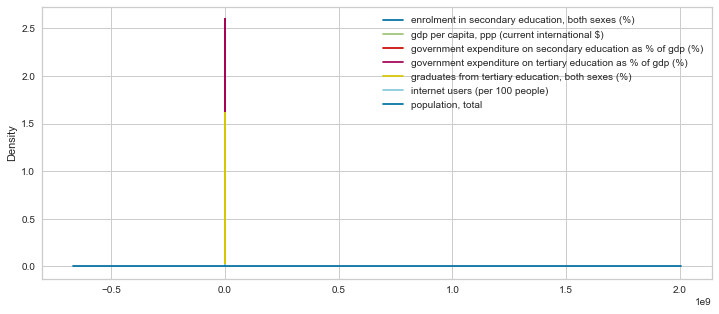

In [374]:
# Before standardisation
X1 = pd.DataFrame(X,columns=X.columns)
X1.plot(kind='density',sharex=True,figsize=(12,5),layout=(10,1))
plt.show()

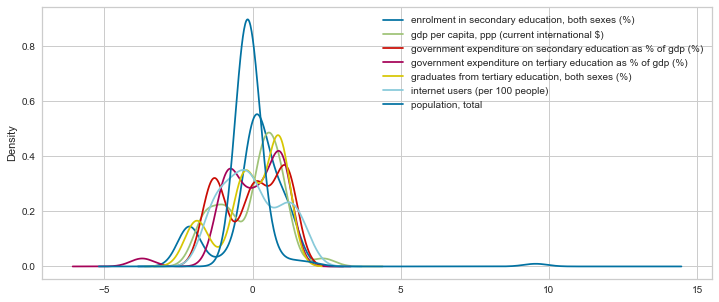

In [375]:
# After standardisation
pd.DataFrame(X_scaled,columns=X.columns).plot(kind='density',sharex=True,figsize=(12,5),layout=(10,1))
plt.show()

In [389]:
X_transformed = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_transformed = X_transformed.reset_index()
X_transformed

,Long Name,"enrolment in secondary education, both sexes (%)","gdp per capita, ppp (current international $)",government expenditure on secondary education as % of gdp (%),government expenditure on tertiary education as % of gdp (%),"graduates from tertiary education, both sexes (%)",internet users (per 100 people),"population, total"
0,Antigua and Barbuda,0.593246,-0.836930,-0.068082,-0.764302,-0.134505,0.176210,-0.274813
1,Arab Republic of Egypt,1.178507,0.855883,0.297580,0.284833,-0.404815,-0.785371,0.342509
2,Argentine Republic,0.593246,-0.836930,-0.068082,-0.764302,-0.134505,0.100495,0.027402
3,Belize,0.593246,-0.836930,-0.068082,-0.764302,-0.134505,-0.535512,-0.273146
4,Bosnia and Herzegovina,0.079165,0.344654,1.128632,0.963686,0.912946,0.015316,-0.248159
...,...,...,...,...,...,...,...,...
99,Ukraine,0.079165,0.344654,1.128632,0.963686,0.912946,-0.721013,0.061547
100,United Arab Emirates,1.178507,0.855883,0.297580,0.284833,-0.404815,0.971218,-0.214736
101,United Kingdom of Great Britain and Northern I...,0.079165,0.344654,1.128632,0.963686,0.912946,1.614797,0.185695
102,United States of America,-0.909451,2.379336,-1.065344,0.963686,-0.235871,1.110913,1.997565


<a id='another_cell_h'></a>

### B. Explained Variance Ratio and Scree plot

In [285]:
# Create the PCA model
model_pca = PCA()

# Fit the model with the data
X_reduced = model_pca.fit_transform(X_scaled)

In [286]:
# Explained variance ratio
model_pca.explained_variance_ratio_.round(2)

array([0.52, 0.17, 0.13, 0.09, 0.06, 0.03, 0.  ])

In [287]:
# Explained variance ratio cumsum
model_pca.explained_variance_ratio_.cumsum().round(2)

array([0.52, 0.68, 0.81, 0.9 , 0.96, 1.  , 1.  ])

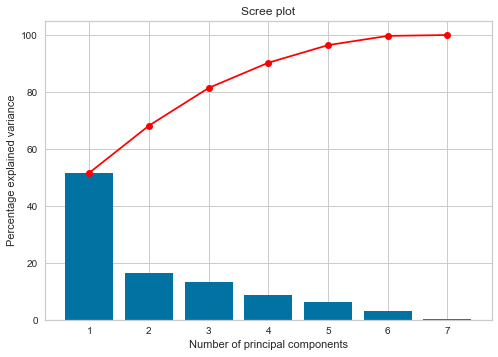

In [288]:
# Scree plot
display_scree_plot(model_pca) 

<div class="alert-success">
<i>☛ We recover 81% inertia from the 3rd component</i></br>

In [289]:
# Number of components to study
num_components = 5
pcs = model_pca.components_ 
pc1 = model_pca.components_[0]
pc2 = model_pca.components_[1]
pc3 = model_pca.components_[2]
pc4 = model_pca.components_[3]

In [290]:
X.columns

Index(['enrolment in secondary education, both sexes (%)',
       'gdp per capita, ppp (current international $)',
       'government expenditure on secondary education as % of gdp (%)',
       'government expenditure on tertiary education as % of gdp (%)',
       'graduates from tertiary education, both sexes (%)',
       'internet users (per 100 people)', 'population, total'],
      dtype='object')

In [102]:
pc1

array([-0.28560123, -0.42362954, -0.39501939, -0.44851421, -0.47513854,
       -0.39482827, -0.01089227])

In [103]:
pc2

array([-0.13606003,  0.30646644, -0.39752042,  0.00907965,  0.06880369,
        0.05075401,  0.84979477])

In [104]:
pc3

array([ 0.84724501,  0.02270093,  0.05565918, -0.42419594,  0.03759874,
       -0.26097962,  0.17057666])

<a id='another_cell_i'></a>

### C. Correlation circles and projections of points

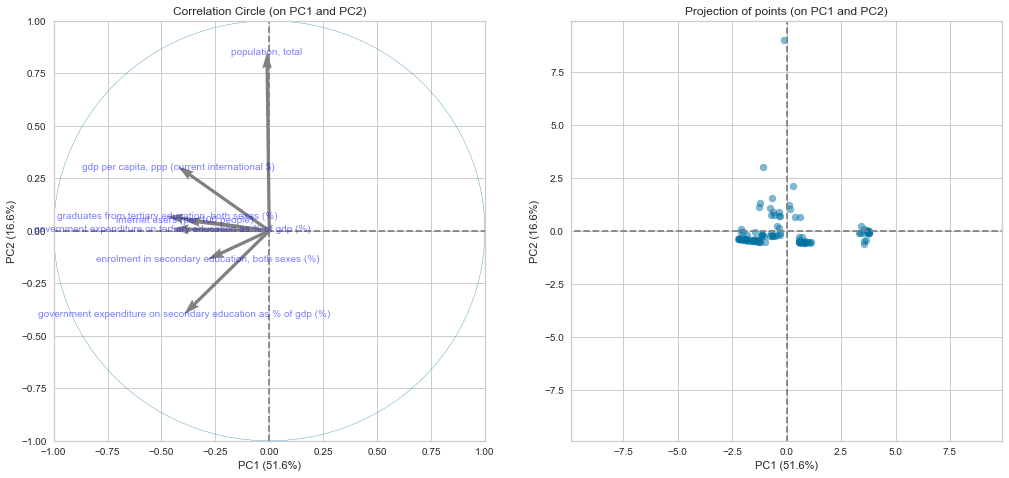

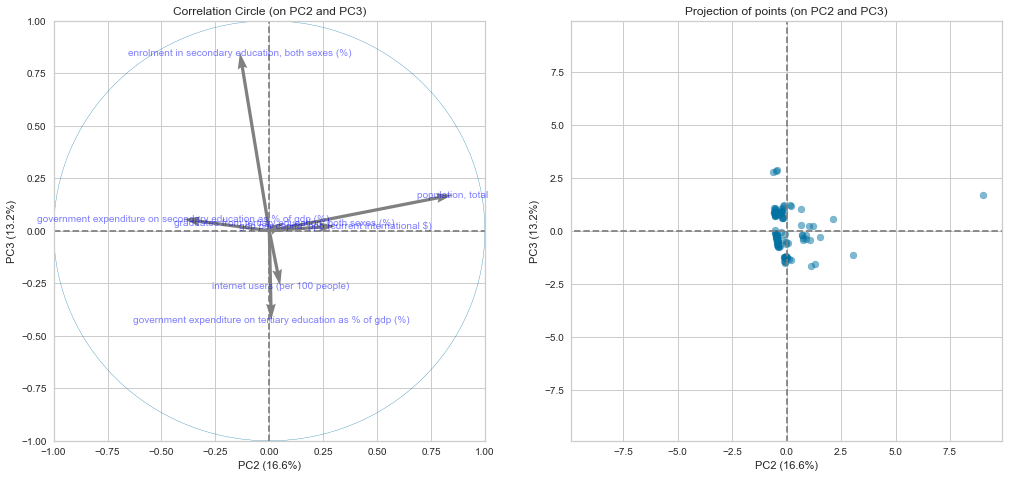

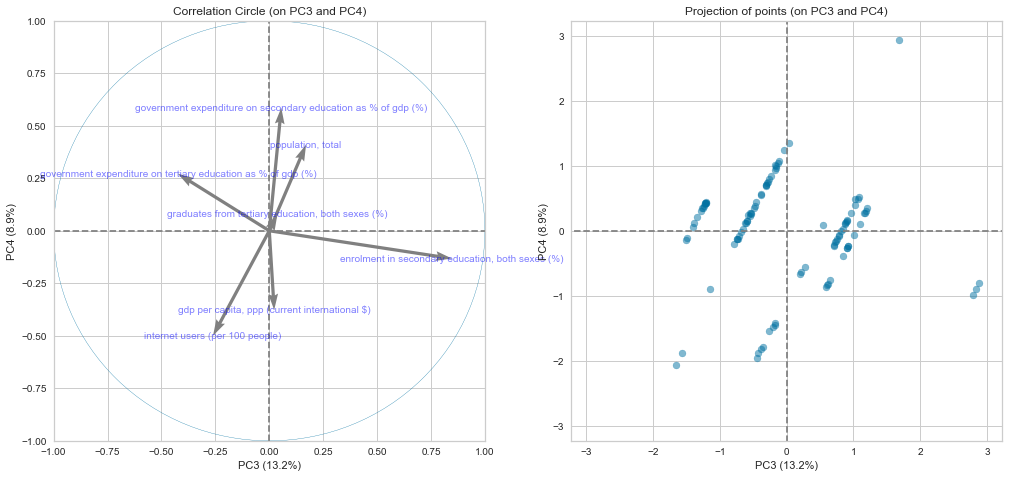

In [106]:
X_projected = model_pca.transform(X_scaled)

plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(0,1)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(0,1)], alpha = 0.5)
plt.show()

print("="*100,"\n")
plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(1,2)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(1,2)], alpha = 0.5)
plt.show()

print("="*100,"\n")
plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(2,3)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(2,3)], alpha = 0.5)
plt.show()

<div class="alert-success">
    <u>Axes interpretation</u> :
<i><br><li><strong> pc1</strong> → Poor countries with small populations, very little spending on education and low internet access
<li><strong> pc2</strong> → Fairly wealthy countries with high demography, low spending on education, average internet access
<li><strong> pc3</strong> → Fairly wealthy countries with average demography, high secondary expenses but low university expenses and low internet access
</i></div>

## III. KMeans clustering

<a id='another_cell_j'></a>

### A. Finding the optimal number of clusters for classification (Elbow method)

In [304]:
!pip install yellowbrick

C:\Users\hp\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

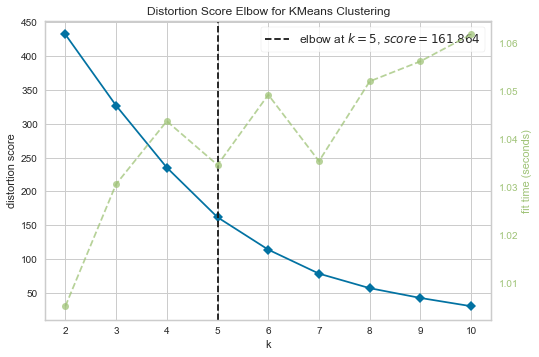

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [305]:
model = KElbowVisualizer(KMeans(), k=10)
model.fit(X_scaled)
model.show()

<div class="alert-success">
<i>☛ According to the elbow curve, the optimal number of clusters is 5
</i></div>

In [313]:
# K-Means model with 5 clusters
model_kmeans = KMeans(n_clusters=5)
model_kmeans.fit(X_scaled)

# Determine which clusters each data point belongs to
clusters2 =  model_kmeans.fit_predict(X_scaled)

# Add the cluster number to the original scaled data
X_clustered2 = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered2["cluster"] = clusters2

X_clustered2.head()

C:\Users\hp\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,"enrolment in secondary education, both sexes (%)","gdp per capita, ppp (current international $)",government expenditure on secondary education as % of gdp (%),government expenditure on tertiary education as % of gdp (%),"graduates from tertiary education, both sexes (%)",internet users (per 100 people),"population, total",cluster
Long Name,,,,,,,,
Antigua and Barbuda,0.593246,-0.836930,-0.068082,-0.764302,-0.134505,0.176210,-0.274813,2
Arab Republic of Egypt,1.178507,0.855883,0.297580,0.284833,-0.404815,-0.785371,0.342509,2
Argentine Republic,0.593246,-0.836930,-0.068082,-0.764302,-0.134505,0.100495,0.027402,2
Belize,0.593246,-0.836930,-0.068082,-0.764302,-0.134505,-0.535512,-0.273146,2
Bosnia and Herzegovina,0.079165,0.344654,1.128632,0.963686,0.912946,0.015316,-0.248159,1


<a id='another_cell_k'></a>

### B. Factorial plane

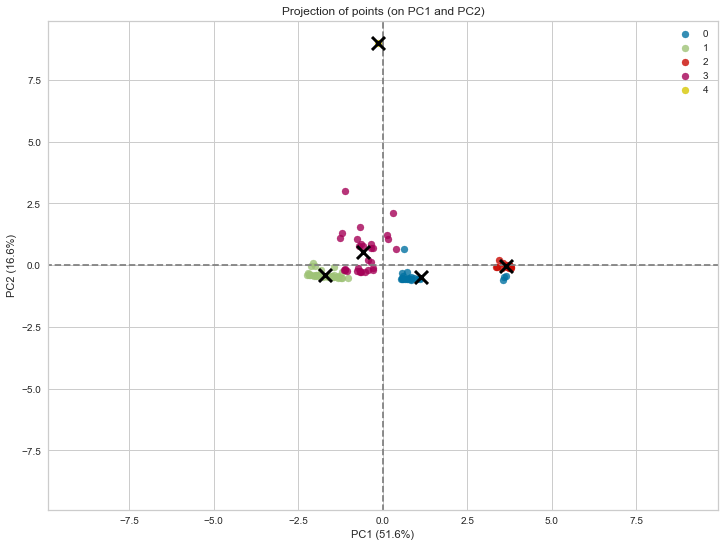

In [111]:
centres_reduced = model_pca.transform(model_kmeans.cluster_centers_)
plt.figure(figsize=(12,9))
display_factorial_planes(X_reduced, 2, model_pca, [(0,1)], illustrative_var = clusters2, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10)
plt.show()

<a id='another_cell_l'></a>

### C. Centroid analysis

In [112]:
kmeans_ =  X_clustered2.groupby(by="cluster").mean()
display(kmeans_)

,"enrolment in secondary education, both sexes (%)","gdp per capita, ppp (current international $)",government expenditure on secondary education as % of gdp (%),government expenditure on tertiary education as % of gdp (%),"graduates from tertiary education, both sexes (%)",internet users (per 100 people),"population, total"
cluster,,,,,,,
0,0.693546,-0.922914,-0.213138,-1.168248,-0.332630,-0.449781,-0.130819
1,0.079165,0.344654,1.128632,0.963686,0.912946,0.623886,-0.154346
2,-2.135336,-1.634616,-1.298038,-0.949444,-1.925308,-1.217326,-0.163928
3,0.466703,1.048631,-0.503553,0.179920,0.085122,0.199992,0.044650
4,-0.079013,0.956890,-1.364522,-0.147164,0.777791,-0.304581,9.553876


<div class="alert-success">
    <u>Clusters interpretation</u> :
<i><li><strong> Cluster 0</strong> → Poor countries with average demography, bad internet access and bad investment in school education</li>
    
<li><strong> Cluster 1 → Rather rich countries with low demography, very strong investment in school education and university and very good level of diploma and internet access</strong></li>
    
<li><strong> Cluster 2</strong> → Very poor countries with low demography, very bad internet access, very low investment in school education and bad level of diploma</li>
    
<li><strong> Cluster 3</strong> → Very rich countries with average demography and good internet access, strong investment only in tertiary education and quite good level of diploma</li>
    
<li><strong> Cluster 4</strong> → Very rich countries with very high demography, low investment in education and bad internet access but quite good level of diploma</li>
</i>

<a id='another_cell_m'></a>

### D. Clusters composition

In [113]:
print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 0 :".format(f =len(X_clustered2[X_clustered2["cluster"]==0]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==0].index.tolist(),"\n")

print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 1 :".format(f =len(X_clustered2[X_clustered2["cluster"]==1]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==1].index.tolist(),"\n")

print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 2 :".format(f =len(X_clustered2[X_clustered2["cluster"]==2]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==2].index.tolist(),"\n")

print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 3 :".format(f =len(X_clustered2[X_clustered2["cluster"]==3]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==3].index.tolist(),"\n")

print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 4 :".format(f =len(X_clustered2[X_clustered2["cluster"]==4]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==4].index.tolist(),"\n")
print("="*100,"\n")


The 22 countries of cluster 0 : 

['Antigua and Barbuda', 'Argentine Republic', 'Belize', 'Commonwealth of Dominica', 'Democratic Socialist Republic of Sri Lanka', 'Dominican Republic', 'Federative Republic of Brazil', 'Jamaica', 'Kingdom of Bhutan', 'Nepal', 'Plurinational State of Bolivia', 'Puerto Rico', 'Republic of Chile', 'Republic of Colombia', 'Republic of Costa Rica', 'Republic of Cuba', 'Republic of Ecuador', 'Republic of Guatemala', 'Republic of Honduras', 'Republic of Panama', 'St. Lucia', 'St. Vincent and the Grenadines'] 


The 36 countries of cluster 1 : 

['Bosnia and Herzegovina', 'Czech Republic', 'Federal Republic of Germany', 'French Republic', 'Georgia', 'Hellenic Republic', 'Hungary', 'Kingdom of Belgium', 'Kingdom of Denmark', 'Kingdom of Norway', 'Kingdom of Spain', 'Kingdom of Sweden', 'Kingdom of the Netherlands', 'Portuguese Republic', 'Principality of Liechtenstein', 'Republic of Albania', 'Republic of Armenia', 'Republic of Austria', 'Republic of Azerbaija

<a id='another_cell_n'></a>

### E. Conclusion (K-Means) and recommendations for <i>academy</i>

<div class="alert-success">
    <u><strong>Cluster 1</strong></u> : this cluster presents the best characteristics for an internationalization.
    <br>These countries generally have a good internet access, a high or even very high GDP for some, and finally they are strong investors in education, with a high level of diploma.
    <br><br>
<strong>☛ We will now study in more detail the data from the countries of cluster 1</strong>

<div class="alert-warning">
<i>☛ All countries of the cluster 1 are in Central Europe
</i></div>

## IV. Scoring of the best cluster and data exploration of the top 3

<a id='another_cell_o'></a>

 ### A.Scoring of the best cluster on 2010 and top 3 selection

<div class="alert-success">
<i>☛ We can recover our standardized dataframe on 2010 to carry out this scoring
</i></div>

In [427]:
#dataframe on cluster 1
df_score = X_transformed[X_transformed['Long Name'].isin(['Bosnia and Herzegovina', 'Czech Republic', 'Federal Republic of Germany', 'French Republic', 'Georgia', 'Hellenic Republic', 'Hungary', 'Kingdom of Belgium', 'Kingdom of Denmark', 'Kingdom of Norway', 'Kingdom of Spain', 'Kingdom of Sweden', 'Kingdom of the Netherlands', 'Portuguese Republic', 'Principality of Liechtenstein', 'Republic of Albania', 'Republic of Armenia', 'Republic of Austria', 'Republic of Azerbaijan', 'Republic of Belarus', 'Republic of Bulgaria', 'Republic of Cyprus', 'Republic of Finland', 'Republic of Kazakhstan', 'Republic of Latvia', 'Republic of Lithuania', 'Republic of Moldova', 'Republic of Serbia', 'Republic of Slovenia', 'Republic of Tajikistan', 'Republic of Turkey', 'Romania', 'Slovak Republic', 'Switzerland', 'Ukraine', 'United Kingdom of Great Britain and Northern Ireland'])]
df_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 4 to 101
Data columns (total 8 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Long Name                                                      36 non-null     object 
 1   enrolment in secondary education, both sexes (%)               36 non-null     float64
 2   gdp per capita, ppp (current international $)                  36 non-null     float64
 3   government expenditure on secondary education as % of gdp (%)  36 non-null     float64
 4   government expenditure on tertiary education as % of gdp (%)   36 non-null     float64
 5   graduates from tertiary education, both sexes (%)              36 non-null     float64
 6   internet users (per 100 people)                                36 non-null     float64
 7   population, total                                              3

<div class="alert-success">
We will weight the internet access and population indicators to assign a score to each country :
</div>

In [428]:
#weighting of important indicators
df_score["internet users (per 100 people)"] = df_score["internet users (per 100 people)"] * 3
df_score["population, total"] = df_score["population, total"] * 2

<ipython-input-428-422deaf54435>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_score["internet users (per 100 people)"] = df_score["internet users (per 100 people)"] * 3
<ipython-input-428-422deaf54435>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_score["population, total"] = df_score["population, total"] * 2


In [478]:
#creation of a score by country
df_score['score'] = df_score["internet users (per 100 people)"] + df_score["population, total"]

<ipython-input-478-983926308642>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_score['score'] = df_score["internet users (per 100 people)"] + df_score["population, total"];


In [430]:
#sort to have the top 3
df_score.sort_values(by=["score"], ascending=False).head(3)

,Long Name,"enrolment in secondary education, both sexes (%)","gdp per capita, ppp (current international $)",government expenditure on secondary education as % of gdp (%),government expenditure on tertiary education as % of gdp (%),"graduates from tertiary education, both sexes (%)",internet users (per 100 people),"population, total",score
29,Kingdom of Norway,0.079165,0.344654,1.128632,0.963686,0.912946,5.797264,-0.479166,5.318098
101,United Kingdom of Great Britain and Northern I...,0.079165,0.344654,1.128632,0.963686,0.912946,4.844390,0.371390,5.215780
34,Kingdom of the Netherlands,0.079165,0.344654,1.128632,0.963686,0.912946,5.494025,-0.306840,5.187185


<div class="alert-success">
<i>☛ Our score goes up in <strong>top 3</strong> with the following countries : <strong> Norway, UK</strong> and <strong>Netherlands</strong>.
</i></div>

<a id='another_cell_p'></a>

 ### B. Exploration of the top 3

In [452]:
#dataframe on cluster 1
df = df[df['Long Name'].isin(['Bosnia and Herzegovina', 'Czech Republic', 'Federal Republic of Germany', 'French Republic', 'Georgia', 'Hellenic Republic', 'Hungary', 'Kingdom of Belgium', 'Kingdom of Denmark', 'Kingdom of Norway', 'Kingdom of Spain', 'Kingdom of Sweden', 'Kingdom of the Netherlands', 'Portuguese Republic', 'Principality of Liechtenstein', 'Republic of Albania', 'Republic of Armenia', 'Republic of Austria', 'Republic of Azerbaijan', 'Republic of Belarus', 'Republic of Bulgaria', 'Republic of Cyprus', 'Republic of Finland', 'Republic of Kazakhstan', 'Republic of Latvia', 'Republic of Lithuania', 'Republic of Moldova', 'Republic of Serbia', 'Republic of Slovenia', 'Republic of Tajikistan', 'Republic of Turkey', 'Romania', 'Slovak Republic', 'Switzerland', 'Ukraine', 'United Kingdom of Great Britain and Northern Ireland'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 137 to 1742
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country Code    364 non-null    object
 1   Long Name       364 non-null    object
 2   Region          364 non-null    object
 3   Indicator Name  364 non-null    object
 4   2010            364 non-null    object
 5   2011            364 non-null    object
 6   2012            364 non-null    object
 7   2013            364 non-null    object
 8   2014            364 non-null    object
 9   2020            364 non-null    object
 10  2040            364 non-null    object
 11  2060            364 non-null    object
dtypes: object(12)
memory usage: 37.0+ KB


In [456]:
#top3 df
df_top_3 = df[df['Country Code'].isin(['NOR','GBR','NLD'])]

#### a. Focus on internet access

In [457]:
#new df only on internet access
df_top3_web = df_top_3[df['Indicator Name'] == 'internet users (per 100 people)']
df_top3_web

<ipython-input-457-1fb719bef9df>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_top3_web = df_top_3[df['Indicator Name'] == 'internet users (per 100 people)']


,Country Code,Long Name,Region,Indicator Name,2010,2011,2012,2013,2014,2020,2040,2060
1232,NLD,Kingdom of the Netherlands,Europe & Central Asia,internet users (per 100 people),90.72,91.419996,92.859992,93.9564,91.666666,91.666666,91.666666,91.666666
1286,NOR,Kingdom of Norway,Europe & Central Asia,internet users (per 100 people),93.39,93.489983,94.649978,95.0534,96.3,96.3,96.3,96.3
1733,GBR,United Kingdom of Great Britain and Northern I...,Europe & Central Asia,internet users (per 100 people),85.0,85.379999,87.479998,89.8441,91.61,91.61,91.61,91.61


In [458]:
#pivot the table to have the years in rows
df_top3_web = pd.melt(df_top3_web, id_vars=['Country Code','Long Name'], value_vars=['2010', '2011', '2012', '2013', '2014', '2020', '2040', '2060'], var_name='Year', value_name='Values')
df_top3_web

,Country Code,Long Name,Year,Values
0,NLD,Kingdom of the Netherlands,2010,90.72
1,NOR,Kingdom of Norway,2010,93.39
2,GBR,United Kingdom of Great Britain and Northern I...,2010,85.0
3,NLD,Kingdom of the Netherlands,2011,91.419996
4,NOR,Kingdom of Norway,2011,93.489983
5,GBR,United Kingdom of Great Britain and Northern I...,2011,85.379999
6,NLD,Kingdom of the Netherlands,2012,92.859992
7,NOR,Kingdom of Norway,2012,94.649978
8,GBR,United Kingdom of Great Britain and Northern I...,2012,87.479998
9,NLD,Kingdom of the Netherlands,2013,93.9564


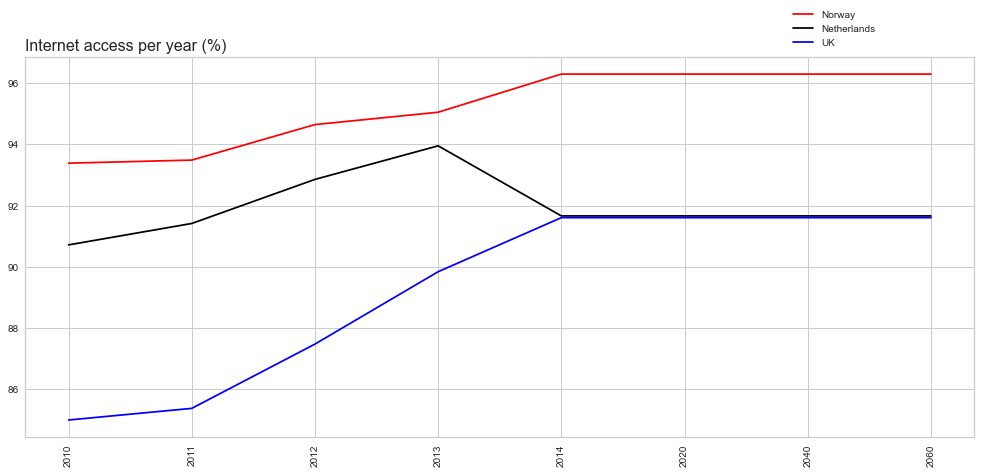

In [467]:
#Web access by country per year
df_nld_web = df_top3_web[df_top3_web["Country Code"] == "NLD"]
df_nor_web = df_top3_web[df_top3_web["Country Code"] == "NOR"]
df_gbr_web = df_top3_web[df_top3_web["Country Code"] == "GBR"]

plt.figure(figsize=(17,7))
plt.plot(df_nor_web["Year"],df_nor_web["Values"],color="red",label="Norway")
plt.plot(df_nld_web["Year"],df_nld_web["Values"],color="black", label="Netherlands")
plt.plot(df_gbr_web["Year"],df_gbr_web["Values"],color="blue", label="UK")
plt.title("Internet access per year (%)", fontsize=16, loc="left")
plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
plt.xticks(rotation = "vertical")
plt.show()

<div class="alert-success">
<i>☛ We note that the Netherlands lost 2 points between 2013 and 2014 and joined England with an internet access rate of approximately 92%, while <strong>Norway exceeded the threshold of 96% internet access</strong> the same year.</i></div>

#### b. Focus on school life expectancy (secondary school)

In [463]:
#new df only on school life expectancy indicator
df_top3_school_life = df_top_3[df['Indicator Name'] == 'school life expectancy, secondary, both sexes (years)']
df_top3_school_life

<ipython-input-463-cdbaa35a55b7>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_top3_school_life = df_top_3[df['Indicator Name'] == 'school life expectancy, secondary, both sexes (years)']


,Country Code,Long Name,Region,Indicator Name,2010,2011,2012,2013,2014,2020,2040,2060
1236,NLD,Kingdom of the Netherlands,Europe & Central Asia,"school life expectancy, secondary, both sexes ...",7.39198,7.72878,7.77729,7.8899,7.90126,7.90126,7.90126,7.90126
1290,NOR,Kingdom of Norway,Europe & Central Asia,"school life expectancy, secondary, both sexes ...",6.83133,6.80306,6.64508,6.76086,6.71282,6.71282,6.71282,6.71282
1737,GBR,United Kingdom of Great Britain and Northern I...,Europe & Central Asia,"school life expectancy, secondary, both sexes ...",7.1208,6.50748,6.40017,8.49736,8.68785,8.68785,8.68785,8.68785


In [464]:
#pivot the table to have the years in rows
df_top3_school_life = pd.melt(df_top3_school_life, id_vars=['Country Code','Long Name'], value_vars=['2010', '2011', '2012', '2013', '2014', '2020', '2040', '2060'], var_name='Year', value_name='Values')
df_top3_school_life

,Country Code,Long Name,Year,Values
0,NLD,Kingdom of the Netherlands,2010,7.39198
1,NOR,Kingdom of Norway,2010,6.83133
2,GBR,United Kingdom of Great Britain and Northern I...,2010,7.1208
3,NLD,Kingdom of the Netherlands,2011,7.72878
4,NOR,Kingdom of Norway,2011,6.80306
5,GBR,United Kingdom of Great Britain and Northern I...,2011,6.50748
6,NLD,Kingdom of the Netherlands,2012,7.77729
7,NOR,Kingdom of Norway,2012,6.64508
8,GBR,United Kingdom of Great Britain and Northern I...,2012,6.40017
9,NLD,Kingdom of the Netherlands,2013,7.8899


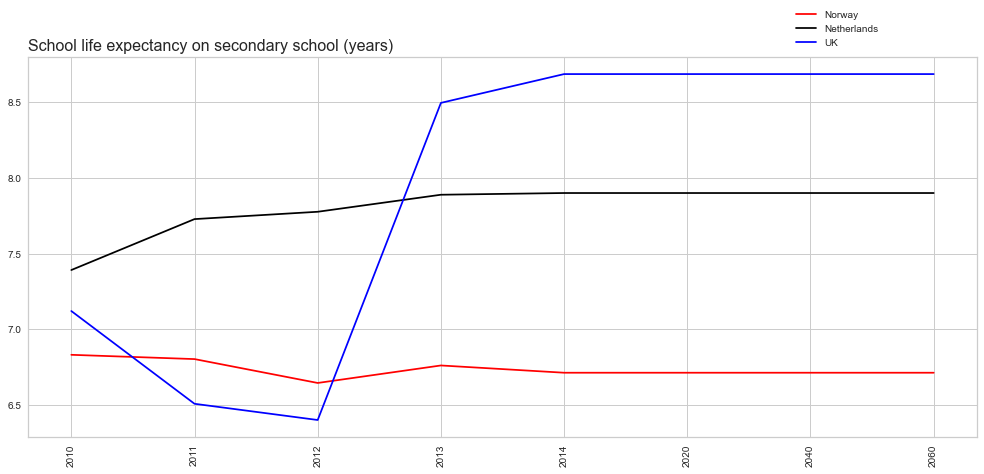

In [470]:
#school life expectancy on high school by country per year
df_nld_school_life = df_top3_school_life[df_top3_school_life["Country Code"] == "NLD"]
df_nor_school_life = df_top3_school_life[df_top3_school_life["Country Code"] == "NOR"]
df_gbr_school_life = df_top3_school_life[df_top3_school_life["Country Code"] == "GBR"]

plt.figure(figsize=(17,7))
plt.plot(df_nor_school_life["Year"],df_nor_school_life["Values"],color="red",label="Norway")
plt.plot(df_nld_school_life["Year"],df_nld_school_life["Values"],color="black", label="Netherlands")
plt.plot(df_gbr_school_life["Year"],df_gbr_school_life["Values"],color="blue", label="UK")
plt.title("School life expectancy on secondary school (years)", fontsize=16, loc="left")
plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
plt.xticks(rotation = "vertical")
plt.show()

<div class="alert-success">
<i>☛ <strong>England increased</strong> from 6.4 <strong>to over 8.5 years of average secondary schooling</strong> between 2012 and 2013, followed by the Netherlands at 7.9 years and Norway at 6.7 years on average.</i></div>

#### c. Wittgenstein projection indicator (mean years of schooling at 25 years old)

In [474]:
#new df only on wittgenstein projection indicator
df_top3_projection = df_top_3[df['Indicator Name'] == 'wittgenstein projection: mean years of schooling. age 25+. total']
df_top3_projection

<ipython-input-474-ec8019e9a9a4>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_top3_projection = df_top_3[df['Indicator Name'] == 'wittgenstein projection: mean years of schooling. age 25+. total']


,Country Code,Long Name,Region,Indicator Name,2010,2011,2012,2013,2014,2020,2040,2060
1238,NLD,Kingdom of the Netherlands,Europe & Central Asia,wittgenstein projection: mean years of schooli...,11.5,11.5,11.5,11.5,11.5,11.9,12.7,13.4
1292,NOR,Kingdom of Norway,Europe & Central Asia,wittgenstein projection: mean years of schooli...,12.6,12.6,12.6,12.6,12.6,13.2,14.1,14.9
1739,GBR,United Kingdom of Great Britain and Northern I...,Europe & Central Asia,wittgenstein projection: mean years of schooli...,10.4,10.4,10.4,10.4,10.4,11.1,12.3,13.5


In [475]:
#pivot the table to have the years in rows
df_top3_projection = pd.melt(df_top3_projection, id_vars=['Country Code','Long Name'], value_vars=['2010', '2011', '2012', '2013', '2014', '2020', '2040', '2060'], var_name='Year', value_name='Values')
df_top3_projection

,Country Code,Long Name,Year,Values
0,NLD,Kingdom of the Netherlands,2010,11.5
1,NOR,Kingdom of Norway,2010,12.6
2,GBR,United Kingdom of Great Britain and Northern I...,2010,10.4
3,NLD,Kingdom of the Netherlands,2011,11.5
4,NOR,Kingdom of Norway,2011,12.6
5,GBR,United Kingdom of Great Britain and Northern I...,2011,10.4
6,NLD,Kingdom of the Netherlands,2012,11.5
7,NOR,Kingdom of Norway,2012,12.6
8,GBR,United Kingdom of Great Britain and Northern I...,2012,10.4
9,NLD,Kingdom of the Netherlands,2013,11.5


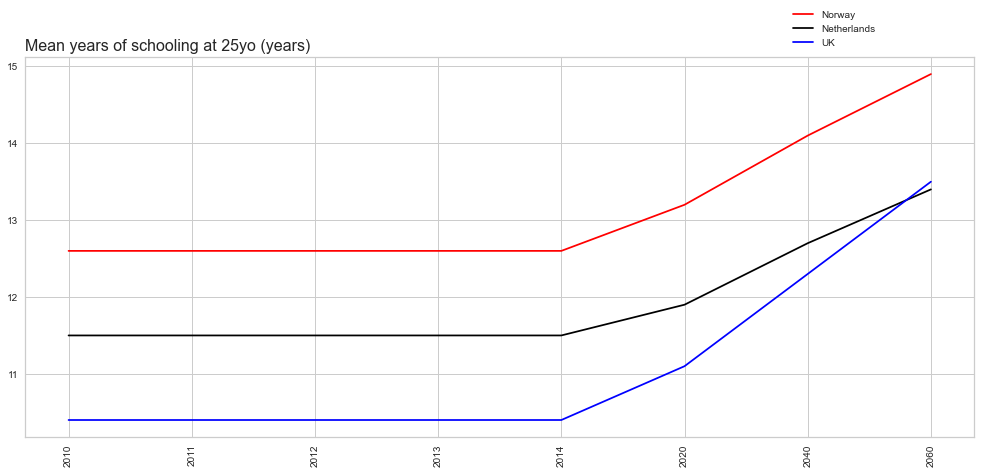

In [477]:
#mean years of schooling at 25yo by country per year
df_nld_projection = df_top3_projection[df_top3_projection["Country Code"] == "NLD"]
df_nor_projection = df_top3_projection[df_top3_projection["Country Code"] == "NOR"]
df_gbr_projection = df_top3_projection[df_top3_projection["Country Code"] == "GBR"]

plt.figure(figsize=(17,7))
plt.plot(df_nor_projection["Year"],df_nor_projection["Values"],color="red",label="Norway")
plt.plot(df_nld_projection["Year"],df_nld_projection["Values"],color="black", label="Netherlands")
plt.plot(df_gbr_projection["Year"],df_gbr_projection["Values"],color="blue", label="UK")
plt.title("Mean years of schooling at 25yo (years)", fontsize=16, loc="left")
plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
plt.xticks(rotation = "vertical")
plt.show()

<div class="alert-success">
<i>☛ <strong>Norway will have an average duration of schooling of 15 years at the age of 25yo in 2060</strong>, followed by England and the Netherlands both at over 13 years.
</i></div>

<a id='another_cell_q'></a>

## Conclusion

<div class="alert-success">
The number of years of secondary education per inhabitant in <strong>Norway</strong> seems quite low (only 6.7 years), however it <strong>is one of the countries with the highest mean years of schooling at age 25 per inhabitant</strong> (about 15 years) <strong>its average duration of schooling in the university being very long</strong>.<br>
Moreover, <strong>Norway has very good internet coverage</strong> (more than 96%).<br>
<br><i><strong>→ Regarding the education World Bank data, we advise Academy to study the possibility of developing its business in Norway to start its international expansion.</strong></i></br>
</i></div>